# Phase 2: Formation Transitions with Advection

This notebook uses **advection-based mass transport** instead of direct alpha updates.

## Key Differences from Standard NCA

| Standard NCA | Advection NCA |
|--------------|---------------|
| NCA outputs alpha updates | NCA outputs velocity |
| Alpha can appear anywhere | Mass is transported |
| Conservation is soft loss | Conservation by construction |
| Movement is emergent | Movement is explicit |

## Physics

```
mass_new = mass - dt * outflow + dt * inflow

where:
  outflow = mass * |velocity|
  inflow = neighbor_mass * neighbor_velocity_toward_me
```

In [33]:
#!cd /workspace/FormationHNCA && git fetch --all && git reset --hard origin/main

In [34]:
#!rm -rf /workspace/FormationHNCA
#!ls
#!git clone https://github.com/JackHopkins/FormationHNCA.git /workspace/FormationHNCA

In [35]:
# Setup
import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

# Determine repo directory based on environment
if os.path.exists("/content"):
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):
    REPO_DIR = "/workspace/FormationHNCA"
else:
    # Local development - use the parent of notebooks directory
    REPO_DIR = os.path.dirname(os.path.dirname(os.path.abspath(".")))
    if not os.path.exists(os.path.join(REPO_DIR, "src")):
        REPO_DIR = os.path.expanduser("~/FormationHNCA")

# Clone or pull repo (only for remote environments)
if os.path.exists("/content") or os.path.exists("/workspace"):
    if os.path.exists(REPO_DIR):
        print(f"Pulling latest changes in {REPO_DIR}...")
        result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
        print(result.stdout or "Already up to date.")
    else:
        print(f"Cloning repository to {REPO_DIR}...")
        subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)
    
    os.chdir(REPO_DIR)
    
    print("Installing JAX with CUDA support...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "jax[cuda12]"], check=True)
    
    print("Installing battle-nca package (fresh)...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--no-cache-dir", "-e", "."], check=True)

# Add src to path (works for both local and remote)
src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print(f"Source path: {src_path}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package (fresh)...

Working directory: /workspace/FormationHNCA
Source path: /workspace/FormationHNCA/src
Setup complete!


In [36]:
!grep -n "def diffuse_mass" /workspace/FormationHNCA/src/battle_nca/core/advection.py

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


74:def diffuse_mass(


In [37]:
# Imports (path already set in previous cell)
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Force reimport to ensure fresh module (important for remote environments)
import importlib
import battle_nca.hierarchy.advection_nca
importlib.reload(battle_nca.hierarchy.advection_nca)

print(f"JAX devices: {jax.devices()}")

JAX devices: [CudaDevice(id=0)]


In [38]:
# Import advection NCA components (after reimport)
from battle_nca.core.advection import advect_mass, check_mass_conservation
from battle_nca.hierarchy.advection_nca import (
    AdvectionNCA, 
    ADVECTION_CHANNELS,
    create_advection_seed,
    create_formation_from_alpha
)
from battle_nca.combat import create_formation_target, rotate_formation
from battle_nca.combat.formations import FormationTypes

print(f"Advection channels: {ADVECTION_CHANNELS.TOTAL}")
print(f"  Mass: {ADVECTION_CHANNELS.MASS}")
print(f"  Velocity: {ADVECTION_CHANNELS.VELOCITY_X}, {ADVECTION_CHANNELS.VELOCITY_Y}")
print(f"  Hidden: {ADVECTION_CHANNELS.HIDDEN_START}-{ADVECTION_CHANNELS.HIDDEN_END}")

# Verify AdvectionNCA has exploration parameters
import inspect
sig = inspect.signature(AdvectionNCA.__init__)
print(f"\nAdvectionNCA parameters: {list(sig.parameters.keys())}")

Advection channels: 16
  Mass: 3
  Velocity: 4, 5
  Hidden: 8-16

AdvectionNCA parameters: ['self', 'num_channels', 'hidden_dim', 'fire_rate', 'advection_dt', 'advection_steps', 'diffusion_rate', 'velocity_noise', 'velocity_damping', 'parent', 'name']


In [39]:
# Configuration
GRID_SIZE = 64
NUM_CHANNELS = ADVECTION_CHANNELS.TOTAL  # 16 channels

print(f"Grid: {GRID_SIZE}x{GRID_SIZE}")
print(f"Channels: {NUM_CHANNELS}")

Grid: 64x64
Channels: 16


Testing advection conservation...
Mass before: 64.0000
Mass after: 64.0000
Conserved: True, Error: 0.000000
After 10 steps - Conserved: True, Error: 0.000000


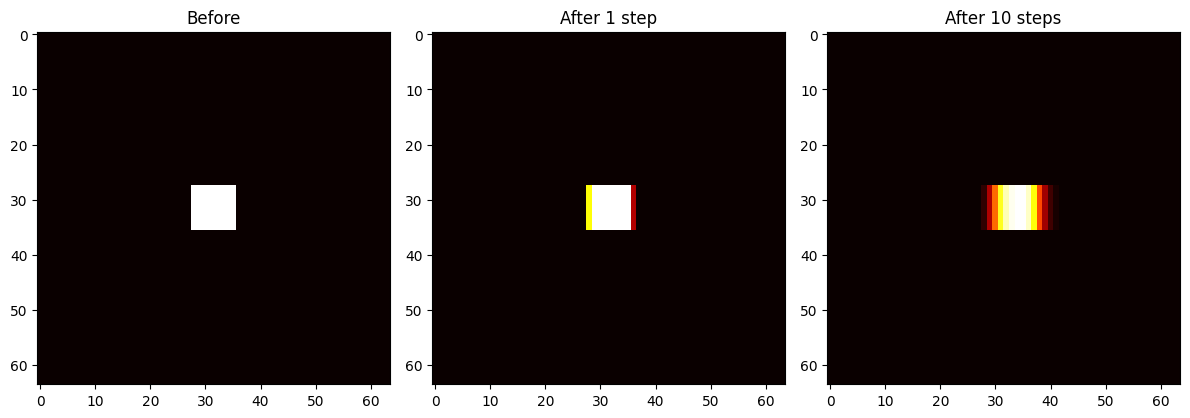

In [40]:
# Test advection physics
print("Testing advection conservation...")

# Create a blob of mass
test_mass = jnp.zeros((GRID_SIZE, GRID_SIZE))
test_mass = test_mass.at[28:36, 28:36].set(1.0)

# Velocity pointing right
test_vx = jnp.ones((GRID_SIZE, GRID_SIZE)) * 0.5
test_vy = jnp.zeros((GRID_SIZE, GRID_SIZE))

# Run advection
mass_before = test_mass
mass_after = advect_mass(mass_before, test_vx, test_vy, dt=0.5)

# Check conservation
conserved, error = check_mass_conservation(mass_before, mass_after)
print(f"Mass before: {float(jnp.sum(mass_before)):.4f}")
print(f"Mass after: {float(jnp.sum(mass_after)):.4f}")
print(f"Conserved: {conserved}, Error: {error:.6f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(mass_before, cmap='hot')
axes[0].set_title('Before')
axes[1].imshow(mass_after, cmap='hot')
axes[1].set_title('After 1 step')

# Run more steps
mass_10 = mass_before
for _ in range(10):
    mass_10 = advect_mass(mass_10, test_vx, test_vy, dt=0.5)
axes[2].imshow(mass_10, cmap='hot')
axes[2].set_title('After 10 steps')

conserved_10, error_10 = check_mass_conservation(mass_before, mass_10)
print(f"After 10 steps - Conserved: {conserved_10}, Error: {error_10:.6f}")

plt.tight_layout()
plt.show()

Target: 200 cells at density 1.0
LINE: 0 cells
SQUARE: 204 cells
WEDGE: 203 cells


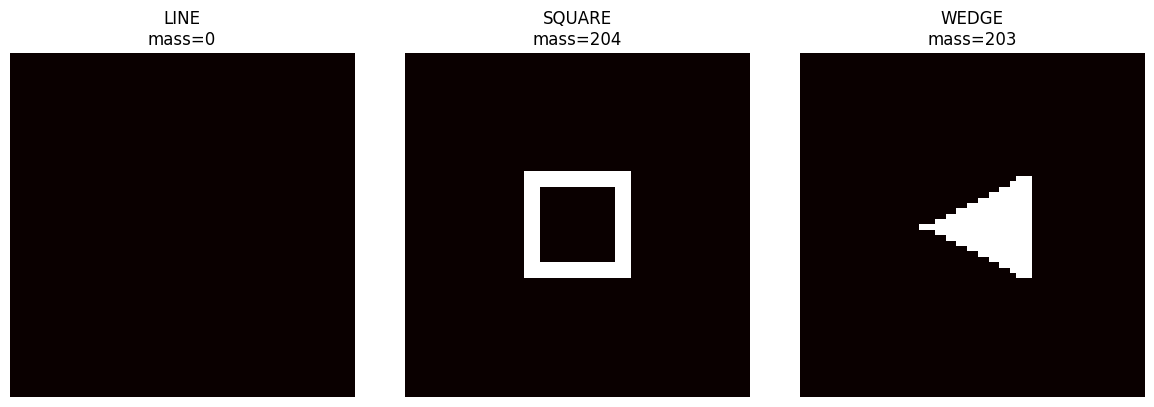

In [41]:
# Create formations with fixed density, scaled size to match target mass
TARGET_MASS = 200.0  # Total mass for all formations
CELL_DENSITY = 1.0   # Each occupied cell has this density

TARGET_CELLS = int(TARGET_MASS / CELL_DENSITY)
print(f"Target: {TARGET_CELLS} cells at density {CELL_DENSITY}")

def create_thin_square(height, width, thickness=1):
    """Create hollow square with thin edges."""
    alpha = jnp.zeros((height, width))
    
    # Calculate size to roughly match target cells
    # Perimeter of square with side s and thickness t: 4*s*t - 4*t^2
    # Solve for s given target cells
    # For thin edges (t=1): cells ≈ 4*s, so s ≈ cells/4 = 50
    side = int(jnp.sqrt(TARGET_CELLS / 4) * 2)  # Approximate
    
    margin_y = (height - side) // 2
    margin_x = (width - side) // 2
    
    top, bottom = margin_y, margin_y + side
    left, right = margin_x, margin_x + side
    
    # Thin walls (1-2 pixels)
    alpha = alpha.at[top:top+thickness, left:right].set(1.0)      # Top
    alpha = alpha.at[bottom-thickness:bottom, left:right].set(1.0) # Bottom
    alpha = alpha.at[top:bottom, left:left+thickness].set(1.0)     # Left
    alpha = alpha.at[top:bottom, right-thickness:right].set(1.0)   # Right
    
    return alpha

def create_thin_line(height, width, thickness=2):
    """Create line formation with specified thickness."""
    alpha = jnp.zeros((height, width))
    
    # Line width to match target cells: width * thickness = TARGET_CELLS
    line_width = int(TARGET_CELLS / thickness)
    
    center_y = height // 2
    margin_x = (width - line_width) // 2
    
    top = center_y - thickness // 2
    bottom = top + thickness
    left = margin_x
    right = margin_x + line_width
    
    alpha = alpha.at[top:bottom, left:right].set(1.0)
    
    return alpha

def create_thin_wedge(height, width):
    """Create wedge/triangle formation."""
    alpha = jnp.zeros((height, width))
    
    # Triangle pointing right
    center_y, center_x = height // 2, width // 2
    
    # Calculate size based on target cells
    # Triangle area ≈ 0.5 * base * height, solve for size
    size = int(jnp.sqrt(TARGET_CELLS * 2))
    
    y_coords, x_coords = jnp.meshgrid(jnp.arange(height), jnp.arange(width), indexing='ij')
    
    # Wedge shape: cells where |y - center| < (x - left_edge) * slope
    left_edge = center_x - size // 2
    right_edge = center_x + size // 2
    
    # Calculate which cells are in the wedge
    in_x_range = (x_coords >= left_edge) & (x_coords <= right_edge)
    x_progress = (x_coords - left_edge) / (size + 1e-6)  # 0 to 1
    max_y_dist = x_progress * (size // 2)  # Grows from 0 to size/2
    y_dist = jnp.abs(y_coords - center_y)
    
    in_wedge = in_x_range & (y_dist <= max_y_dist)
    alpha = jnp.where(in_wedge, 1.0, 0.0)
    
    return alpha

def scale_formation_to_mass(alpha, target_mass, density=1.0):
    """Scale formation spatially to achieve target mass while keeping fixed density."""
    binary = (alpha > 0.5).astype(jnp.float32)
    current_cells = float(jnp.sum(binary))
    
    if current_cells == 0:
        return alpha
    
    target_cells = target_mass / density
    scale = jnp.sqrt(target_cells / current_cells)
    
    h, w = alpha.shape
    center_y, center_x = h // 2, w // 2
    
    y_coords, x_coords = jnp.meshgrid(jnp.arange(h), jnp.arange(w), indexing='ij')
    
    src_y = (y_coords - center_y) / scale + center_y
    src_x = (x_coords - center_x) / scale + center_x
    
    src_y_int = jnp.clip(jnp.round(src_y).astype(jnp.int32), 0, h-1)
    src_x_int = jnp.clip(jnp.round(src_x).astype(jnp.int32), 0, w-1)
    
    scaled = binary[src_y_int, src_x_int]
    scaled = jnp.where(scaled > 0.5, density, 0.0)
    
    return scaled

# Create formations with thin edges
formations = {}

# Line: 2 pixels thick
line_alpha = create_thin_line(GRID_SIZE, GRID_SIZE, thickness=2)
line_alpha = scale_formation_to_mass(line_alpha, TARGET_MASS, CELL_DENSITY)
formations['LINE'] = line_alpha
print(f"LINE: {float(jnp.sum(line_alpha)):.0f} cells")

# Square: 1-2 pixels thick edges
square_alpha = create_thin_square(GRID_SIZE, GRID_SIZE, thickness=2)
square_alpha = scale_formation_to_mass(square_alpha, TARGET_MASS, CELL_DENSITY)
formations['SQUARE'] = square_alpha
print(f"SQUARE: {float(jnp.sum(square_alpha)):.0f} cells")

# Wedge
wedge_alpha = create_thin_wedge(GRID_SIZE, GRID_SIZE)
wedge_alpha = scale_formation_to_mass(wedge_alpha, TARGET_MASS, CELL_DENSITY)
formations['WEDGE'] = wedge_alpha
print(f"WEDGE: {float(jnp.sum(wedge_alpha)):.0f} cells")

# Visualize formations
fig, axes = plt.subplots(1, len(formations), figsize=(12, 4))
for ax, (name, alpha) in zip(axes, formations.items()):
    ax.imshow(alpha, cmap='hot', vmin=0, vmax=1)
    mass = float(jnp.sum(alpha))
    cells = float(jnp.sum(alpha > 0.5))
    ax.set_title(f"{name}\nmass={mass:.0f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [42]:
# Initialize AdvectionNCA with exploration parameters
advection_nca = AdvectionNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=64,
    fire_rate=0.5,
    advection_dt=0.25,
    advection_steps=2,
    diffusion_rate=0.08,      # Mass spreads to explore space
    velocity_noise=0.25,      # Random velocity for exploration
    velocity_damping=0.95     # Velocity decay per step (helps cells settle)
)

# Initialize parameters
key = jax.random.PRNGKey(42)
init_key, train_key = jax.random.split(key)

# Create a sample seed for initialization
sample_seed = create_formation_from_alpha(formations['LINE'])

# Dummy signal (target velocity)
dummy_signal = jnp.zeros((GRID_SIZE, GRID_SIZE, 4))

# Initialize
params = advection_nca.init(init_key, sample_seed, jax.random.PRNGKey(0), parent_signal=dummy_signal)['params']

# Count parameters
param_count = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(f"AdvectionNCA parameters: {param_count:,}")
print(f"\nExploration settings:")
print(f"  - diffusion_rate: {advection_nca.diffusion_rate} (mass spreads each step)")
print(f"  - velocity_noise: {advection_nca.velocity_noise} (random velocity component)")
print(f"  - velocity_damping: {advection_nca.velocity_damping} (velocity decay per step)")

AdvectionNCA parameters: 3,853

Exploration settings:
  - diffusion_rate: 0.08 (mass spreads each step)
  - velocity_noise: 0.25 (random velocity component)
  - velocity_damping: 0.95 (velocity decay per step)


In [43]:
# Create training state
from battle_nca.training import create_optimizer

optimizer = create_optimizer(
    learning_rate=2e-3,
    gradient_clip=1.0,
    use_schedule=True,
    warmup_steps=200,
    decay_steps=4000
)

state = train_state.TrainState.create(
    apply_fn=advection_nca.apply,
    params=params,
    tx=optimizer
)

print(f"Optimizer created with warmup schedule")

Optimizer created with warmup schedule


Signal shape: (64, 64, 4)
Target mass: 0.0


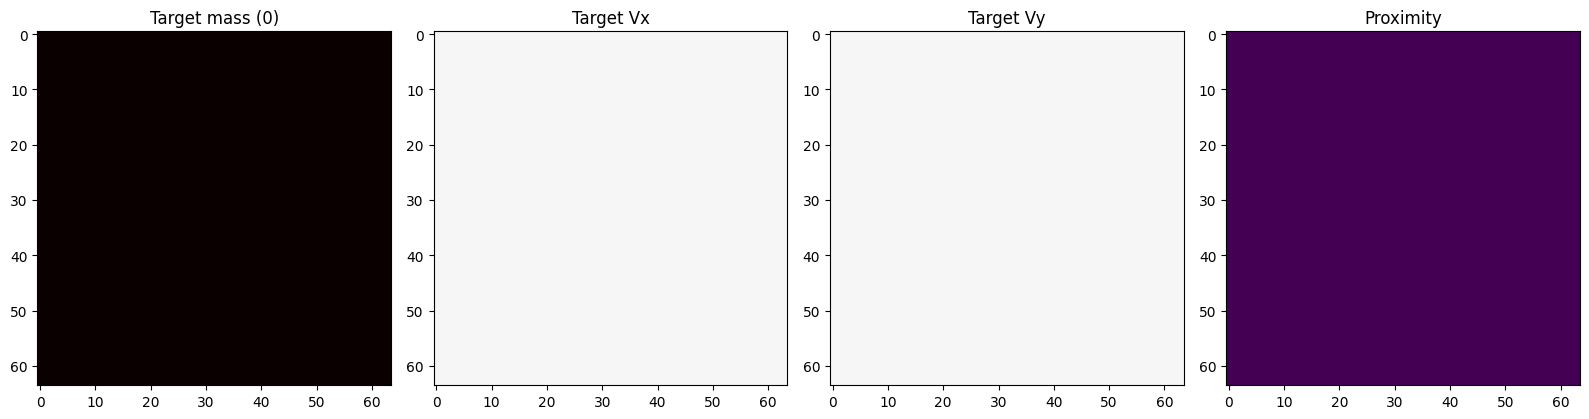

In [44]:
# Create goal signal from target formation
def create_formation_from_alpha(alpha, rgb=(1.0, 0.0, 0.0)):
    """Create full state from alpha/mass pattern (preserves mass)."""
    h, w = alpha.shape
    state = jnp.zeros((h, w, ADVECTION_CHANNELS.TOTAL))
    
    # Set RGB where mass exists
    has_mass = alpha > 0.01
    state = state.at[..., 0].set(rgb[0] * has_mass)
    state = state.at[..., 1].set(rgb[1] * has_mass)
    state = state.at[..., 2].set(rgb[2] * has_mass)
    
    # Set mass (preserve exact values)
    state = state.at[..., ADVECTION_CHANNELS.MASS].set(alpha)
    
    # Initialize hidden channels
    state = state.at[..., ADVECTION_CHANNELS.HIDDEN_START:].set(0.1 * has_mass[..., None])
    
    return state

def create_goal_signal(target_alpha, current_mass):
    """Create signal that guides NCA toward target.
    
    Signal contains:
    - Channel 0: Target mass (where to be)
    - Channel 1-2: Target velocity (direction toward target)
    - Channel 3: Distance to target (proximity)
    """
    # Blur target to create potential field
    blurred = target_alpha
    for _ in range(4):
        padded = jnp.pad(blurred, ((1, 1), (1, 1)), mode='edge')
        blurred = (
            padded[:-2, :-2] + padded[:-2, 1:-1] + padded[:-2, 2:] +
            padded[1:-1, :-2] + padded[1:-1, 1:-1] + padded[1:-1, 2:] +
            padded[2:, :-2] + padded[2:, 1:-1] + padded[2:, 2:]
        ) / 9.0
    
    # Gradient = target velocity
    padded = jnp.pad(blurred, ((1, 1), (1, 1)), mode='edge')
    target_vx = (padded[1:-1, 2:] - padded[1:-1, :-2]) / 2.0
    target_vy = (padded[2:, 1:-1] - padded[:-2, 1:-1]) / 2.0
    
    # Normalize
    mag = jnp.sqrt(target_vx**2 + target_vy**2 + 1e-8)
    target_vx = target_vx / mag
    target_vy = target_vy / mag
    
    # Proximity (how close to target)
    proximity = blurred / (jnp.max(blurred) + 1e-8)
    
    # Stack into signal
    signal = jnp.stack([target_alpha, target_vx, target_vy, proximity], axis=-1)
    return signal

# Test signal creation
target_alpha = formations['LINE']
# Create a test initial state (Gaussian blob for testing)
test_initial = jnp.zeros((GRID_SIZE, GRID_SIZE))
test_initial = test_initial.at[56:72, 56:72].set(1.0)  # Center blob

test_signal = create_goal_signal(target_alpha, test_initial)
print(f"Signal shape: {test_signal.shape}")
print(f"Target mass: {float(jnp.sum(target_alpha)):.1f}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(test_signal[..., 0], cmap='hot')
axes[0].set_title(f'Target mass ({float(jnp.sum(test_signal[..., 0])):.0f})')
axes[1].imshow(test_signal[..., 1], cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Target Vx')
axes[2].imshow(test_signal[..., 2], cmap='RdBu', vmin=-1, vmax=1)
axes[2].set_title('Target Vy')
axes[3].imshow(test_signal[..., 3], cmap='viridis')
axes[3].set_title('Proximity')
plt.tight_layout()
plt.show()

In [45]:
# Training configuration
NUM_STEPS = 128  # Steps per trajectory
BATCH_SIZE = 16
ACCUM_STEPS = 4  # Accumulate gradients: effective batch = 8 * 4 = 32
NUM_EPOCHS = 4000
VIZ_INTERVAL = 400

print(f"Training config:")
print(f"  Steps per trajectory: {NUM_STEPS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Accumulation steps: {ACCUM_STEPS}")
print(f"  Effective batch size: {BATCH_SIZE * ACCUM_STEPS}")
print(f"  Epochs: {NUM_EPOCHS}")

Training config:
  Steps per trajectory: 128
  Batch size: 16
  Accumulation steps: 4
  Effective batch size: 64
  Epochs: 4000


In [46]:
# Training step
@jax.jit
def train_step(state, batch, target_alpha, key):
    """Single training step.
    
    Loss:
    1. Mass distribution should match target
    2. Velocity should point toward target (auxiliary)
    """
    batch_size = batch.shape[0]
    
    def loss_fn(params):
        keys = jax.random.split(key, NUM_STEPS)
        
        # Create goal signal and broadcast to batch
        signal = create_goal_signal(target_alpha, batch[0, ..., ADVECTION_CHANNELS.MASS])
        signal_batch = jnp.broadcast_to(signal[None, ...], (batch_size,) + signal.shape)
        
        # Run trajectory
        def step(carry, step_key):
            new_state = advection_nca.apply(
                {'params': params}, carry, step_key, parent_signal=signal_batch
            )
            return new_state, new_state
        
        final_state, trajectory = jax.lax.scan(step, batch, keys)
        
        # Loss 1: Final mass should match target
        final_mass = final_state[..., ADVECTION_CHANNELS.MASS]
        # Broadcast target to batch
        target_batch = jnp.broadcast_to(target_alpha[None, ...], final_mass.shape)
        mass_loss = jnp.mean((final_mass - target_batch) ** 2)
        
        # Loss 2: Velocity should align with target direction (where mass exists)
        final_vx = final_state[..., ADVECTION_CHANNELS.VELOCITY_X]
        final_vy = final_state[..., ADVECTION_CHANNELS.VELOCITY_Y]
        target_vx = signal_batch[..., 1]
        target_vy = signal_batch[..., 2]
        
        # Only penalize velocity where there's mass to move
        mass_weight = final_mass + 0.1  # Small weight everywhere for exploration
        velocity_loss = jnp.mean(mass_weight * ((final_vx - target_vx)**2 + (final_vy - target_vy)**2))
        
        # Total loss
        total_loss = mass_loss + 0.1 * velocity_loss
        
        return total_loss, (final_state, mass_loss, velocity_loss)
    
    (loss, (final_state, mass_loss, vel_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, mass_loss, vel_loss, final_state

print("Training step compiled")

Training step compiled


Creating Gaussian blobs...
Creating lightly noisy formations...
Creating heavily noisy formations...
Adding clean formations...

Pool size: 256
Pool composition:
  - Gaussian blobs: 64
  - Light noise: 64
  - Heavy noise: 64
  - Clean: 64
Pool mass: min=0, max=204, mean=150


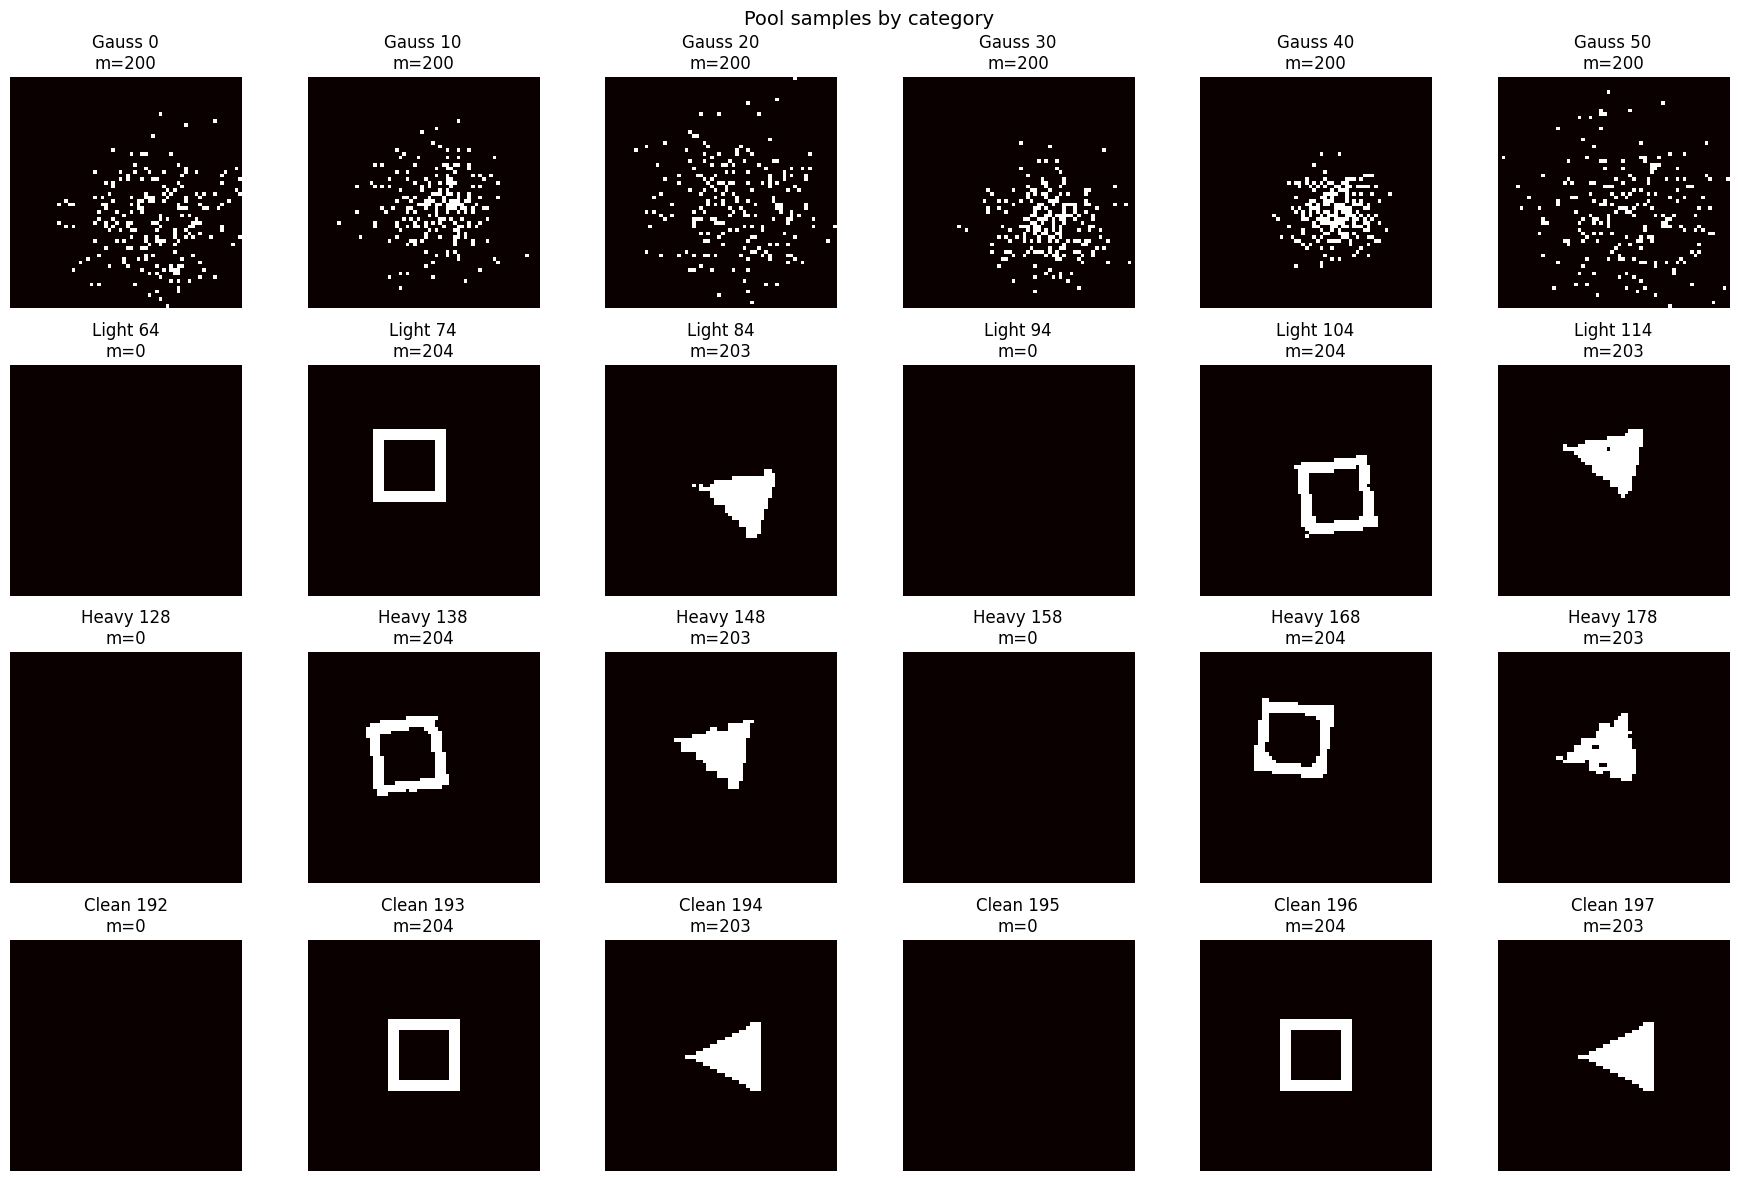

In [47]:
# Pool-based training with diverse initial states
formation_names = list(formations.keys())

def create_gaussian_blob(height, width, target_mass, density=1.0, sigma=8.0, key=None):
    """Create initial state with Gaussian distribution around center."""
    if key is None:
        key = jax.random.PRNGKey(0)
    
    state = jnp.zeros((height, width, ADVECTION_CHANNELS.TOTAL))
    
    # Create Gaussian probability field (with random center offset)
    key, k_offset = jax.random.split(key)
    offset_y = int(jax.random.randint(k_offset, (), -8, 9))
    offset_x = int(jax.random.randint(k_offset, (), -8, 9))
    
    cy, cx = height // 2 + offset_y, width // 2 + offset_x
    y_coords, x_coords = jnp.meshgrid(jnp.arange(height), jnp.arange(width), indexing='ij')
    
    dist_sq = (y_coords - cy)**2 + (x_coords - cx)**2
    prob = jnp.exp(-dist_sq / (2 * sigma**2))
    prob = prob / jnp.sum(prob)
    
    # Sample cells based on probability
    num_cells = int(target_mass / density)
    flat_prob = prob.ravel()
    
    key, subkey = jax.random.split(key)
    gumbel_noise = jax.random.gumbel(subkey, shape=flat_prob.shape)
    scores = jnp.log(flat_prob + 1e-10) + gumbel_noise
    
    threshold = jnp.sort(scores)[-num_cells]
    selected = (scores >= threshold).reshape(height, width).astype(jnp.float32)
    
    state = state.at[..., ADVECTION_CHANNELS.MASS].set(selected * density)
    state = state.at[..., 0].set(selected)
    state = state.at[..., ADVECTION_CHANNELS.HIDDEN_START:].set(0.1 * selected[..., None])
    
    return state

def add_heavy_noise_to_formation(alpha, key, noise_intensity=0.5):
    """Add significant noise to a formation while preserving total mass.
    
    Applies multiple perturbations:
    - Random shifts
    - Rotation
    - Erosion (remove edge cells)
    - Dilation (grow at edges)
    - Random cell removal/addition
    - Fragmentation
    """
    h, w = alpha.shape
    target_mass = float(jnp.sum(alpha))
    
    key, k1, k2, k3, k4, k5, k6, k7 = jax.random.split(key, 8)
    
    result = alpha.copy()
    
    # 1. Random shift (larger range)
    shift_y = int(jax.random.randint(k1, (), -8, 9))
    shift_x = int(jax.random.randint(k1, (), -8, 9))
    result = jnp.roll(jnp.roll(result, shift_y, axis=0), shift_x, axis=1)
    
    # 2. Random rotation (small angle)
    angle = float(jax.random.uniform(k2, (), minval=-0.3, maxval=0.3))  # ~±17 degrees
    if abs(angle) > 0.05:
        cy, cx = h // 2, w // 2
        y_coords, x_coords = jnp.meshgrid(jnp.arange(h), jnp.arange(w), indexing='ij')
        cos_a, sin_a = jnp.cos(angle), jnp.sin(angle)
        src_y = cos_a * (y_coords - cy) + sin_a * (x_coords - cx) + cy
        src_x = -sin_a * (y_coords - cy) + cos_a * (x_coords - cx) + cx
        src_y_int = jnp.clip(jnp.round(src_y).astype(jnp.int32), 0, h-1)
        src_x_int = jnp.clip(jnp.round(src_x).astype(jnp.int32), 0, w-1)
        result = result[src_y_int, src_x_int]
    
    # 3. Multiple rounds of erosion
    erosion_rounds = int(jax.random.randint(k3, (), 1, 4))  # 1-3 rounds
    for _ in range(erosion_rounds):
        padded = jnp.pad(result, ((1,1), (1,1)), mode='constant')
        neighbors = (padded[:-2, 1:-1] + padded[2:, 1:-1] + 
                     padded[1:-1, :-2] + padded[1:-1, 2:]) / 4
        noise = jax.random.uniform(k3, (h, w))
        k3, _ = jax.random.split(k3)
        # Erode edges with probability proportional to noise_intensity
        edge_mask = (result > 0.5) & (neighbors < 0.75) & (noise < noise_intensity * 0.4)
        result = jnp.where(edge_mask, 0.0, result)
    
    # 4. Multiple rounds of dilation
    dilation_rounds = int(jax.random.randint(k4, (), 1, 4))
    for _ in range(dilation_rounds):
        padded = jnp.pad(result, ((1,1), (1,1)), mode='constant')
        neighbors = (padded[:-2, 1:-1] + padded[2:, 1:-1] + 
                     padded[1:-1, :-2] + padded[1:-1, 2:]) / 4
        noise = jax.random.uniform(k4, (h, w))
        k4, _ = jax.random.split(k4)
        grow_mask = (result < 0.5) & (neighbors > 0.25) & (noise < noise_intensity * 0.3)
        result = jnp.where(grow_mask, 1.0, result)
    
    # 5. Random holes (remove random cells)
    hole_noise = jax.random.uniform(k5, (h, w))
    hole_mask = (result > 0.5) & (hole_noise < noise_intensity * 0.15)
    result = jnp.where(hole_mask, 0.0, result)
    
    # 6. Fragment: occasionally split the formation
    if jax.random.uniform(k6, ()) < noise_intensity * 0.3:
        # Create a random line that cuts through
        cut_angle = float(jax.random.uniform(k6, (), minval=0, maxval=jnp.pi))
        cut_offset = float(jax.random.uniform(k6, (), minval=-5, maxval=5))
        y_coords, x_coords = jnp.meshgrid(jnp.arange(h), jnp.arange(w), indexing='ij')
        cut_line = (y_coords - h//2) * jnp.cos(cut_angle) + (x_coords - w//2) * jnp.sin(cut_angle) + cut_offset
        cut_mask = (jnp.abs(cut_line) < 2) & (result > 0.5)
        result = jnp.where(cut_mask, 0.0, result)
    
    # 7. Renormalize to target mass
    result = jnp.where(result > 0.5, 1.0, 0.0)
    current_mass = jnp.sum(result)
    
    if current_mass > 0:
        diff = int(target_mass - current_mass)
        
        if diff > 0:
            # Need to add cells
            padded = jnp.pad(result, ((1,1), (1,1)), mode='constant')
            neighbors = (padded[:-2, 1:-1] + padded[2:, 1:-1] + 
                         padded[1:-1, :-2] + padded[1:-1, 2:]) / 4
            candidates = (result < 0.5) & (neighbors > 0.1)
            candidate_scores = neighbors * candidates + jax.random.uniform(k7, (h, w)) * 0.01
            flat_scores = candidate_scores.ravel()
            num_to_add = min(diff, int(jnp.sum(candidates)))
            if num_to_add > 0:
                threshold = jnp.sort(flat_scores)[-num_to_add]
                add_mask = (candidate_scores >= threshold) & candidates
                result = jnp.where(add_mask, 1.0, result)
        elif diff < 0:
            # Need to remove cells
            padded = jnp.pad(result, ((1,1), (1,1)), mode='constant')
            neighbors = (padded[:-2, 1:-1] + padded[2:, 1:-1] + 
                         padded[1:-1, :-2] + padded[1:-1, 2:]) / 4
            # Remove from edges first
            edge_scores = (1 - neighbors) * (result > 0.5) + jax.random.uniform(k7, (h, w)) * 0.01
            flat_scores = edge_scores.ravel()
            num_to_remove = min(-diff, int(jnp.sum(result > 0.5)))
            if num_to_remove > 0:
                threshold = jnp.sort(flat_scores)[-num_to_remove]
                remove_mask = (edge_scores >= threshold) & (result > 0.5)
                result = jnp.where(remove_mask, 0.0, result)
    
    return result

def create_noisy_formation(alpha, key, intensity=0.5):
    """Create a noisy version of a formation."""
    noisy = add_heavy_noise_to_formation(alpha, key, noise_intensity=intensity)
    return create_formation_from_alpha(noisy)

# Initialize pool with diverse states
pool_size = 256
key = jax.random.PRNGKey(42)

pool_list = []

# 1/4: Gaussian blobs with varying sigma
print("Creating Gaussian blobs...")
for i in range(pool_size // 4):
    key, subkey = jax.random.split(key)
    sigma = 5.0 + jax.random.uniform(subkey, (), minval=0, maxval=8)  # sigma 5-13
    key, subkey = jax.random.split(key)
    blob = create_gaussian_blob(GRID_SIZE, GRID_SIZE, TARGET_MASS, CELL_DENSITY, float(sigma), subkey)
    pool_list.append(blob)

# 1/4: Lightly noisy formations
print("Creating lightly noisy formations...")
for i in range(pool_size // 4):
    key, subkey = jax.random.split(key)
    form_idx = i % len(formation_names)
    form_name = formation_names[form_idx]
    noisy_state = create_noisy_formation(formations[form_name], subkey, intensity=0.3)
    pool_list.append(noisy_state)

# 1/4: Heavily noisy formations
print("Creating heavily noisy formations...")
for i in range(pool_size // 4):
    key, subkey = jax.random.split(key)
    form_idx = i % len(formation_names)
    form_name = formation_names[form_idx]
    noisy_state = create_noisy_formation(formations[form_name], subkey, intensity=0.7)
    pool_list.append(noisy_state)

# 1/4: Clean formations
print("Adding clean formations...")
for i in range(pool_size - len(pool_list)):
    form_idx = i % len(formation_names)
    form_name = formation_names[form_idx]
    clean_state = create_formation_from_alpha(formations[form_name])
    pool_list.append(clean_state)

pool = jnp.stack(pool_list)

# Verify mass consistency
pool_masses = jnp.sum(pool[..., ADVECTION_CHANNELS.MASS], axis=(1, 2))
print(f"\nPool size: {pool_size}")
print(f"Pool composition:")
print(f"  - Gaussian blobs: {pool_size//4}")
print(f"  - Light noise: {pool_size//4}")
print(f"  - Heavy noise: {pool_size//4}")
print(f"  - Clean: {pool_size - 3*(pool_size//4)}")
print(f"Pool mass: min={float(jnp.min(pool_masses)):.0f}, max={float(jnp.max(pool_masses)):.0f}, mean={float(jnp.mean(pool_masses)):.0f}")

# Visualize samples from each category
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

# Row 0: Gaussian blobs
for j in range(6):
    idx = j * (pool_size // 24)
    mass = pool[idx, ..., ADVECTION_CHANNELS.MASS]
    axes[0, j].imshow(mass, cmap='hot', vmin=0, vmax=1)
    axes[0, j].set_title(f"Gauss {idx}\nm={float(jnp.sum(mass)):.0f}")
    axes[0, j].axis('off')

# Row 1: Light noise
for j in range(6):
    idx = pool_size // 4 + j * (pool_size // 24)
    mass = pool[idx, ..., ADVECTION_CHANNELS.MASS]
    axes[1, j].imshow(mass, cmap='hot', vmin=0, vmax=1)
    axes[1, j].set_title(f"Light {idx}\nm={float(jnp.sum(mass)):.0f}")
    axes[1, j].axis('off')

# Row 2: Heavy noise
for j in range(6):
    idx = pool_size // 2 + j * (pool_size // 24)
    mass = pool[idx, ..., ADVECTION_CHANNELS.MASS]
    axes[2, j].imshow(mass, cmap='hot', vmin=0, vmax=1)
    axes[2, j].set_title(f"Heavy {idx}\nm={float(jnp.sum(mass)):.0f}")
    axes[2, j].axis('off')

# Row 3: Clean
for j in range(6):
    idx = 3 * pool_size // 4 + j
    mass = pool[idx, ..., ADVECTION_CHANNELS.MASS]
    axes[3, j].imshow(mass, cmap='hot', vmin=0, vmax=1)
    axes[3, j].set_title(f"Clean {idx}\nm={float(jnp.sum(mass)):.0f}")
    axes[3, j].axis('off')

plt.suptitle('Pool samples by category', fontsize=14)
plt.tight_layout()
plt.show()

Starting training with gradient accumulation...
Effective batch size: 16 x 4 = 64
Evaluation: 512 steps
Epoch    0 | Loss: 0.0156 | Mass: 0.0147 | Vel: 0.0092 | Conserv: 0.992
Epoch   50 | Loss: 0.0566 | Mass: 0.0444 | Vel: 0.1217 | Conserv: 0.000
Epoch  100 | Loss: 0.0245 | Mass: 0.0221 | Vel: 0.0241 | Conserv: 0.000
Epoch  150 | Loss: 0.0322 | Mass: 0.0300 | Vel: 0.0224 | Conserv: 0.000
Epoch  200 | Loss: 0.0292 | Mass: 0.0278 | Vel: 0.0136 | Conserv: 0.913
Epoch  250 | Loss: 0.0305 | Mass: 0.0286 | Vel: 0.0191 | Conserv: 0.999
Epoch  300 | Loss: 0.0410 | Mass: 0.0389 | Vel: 0.0211 | Conserv: 0.997
Epoch  350 | Loss: 0.0116 | Mass: 0.0105 | Vel: 0.0115 | Conserv: 1.000
Epoch  400 | Loss: 0.0326 | Mass: 0.0304 | Vel: 0.0218 | Conserv: 0.000


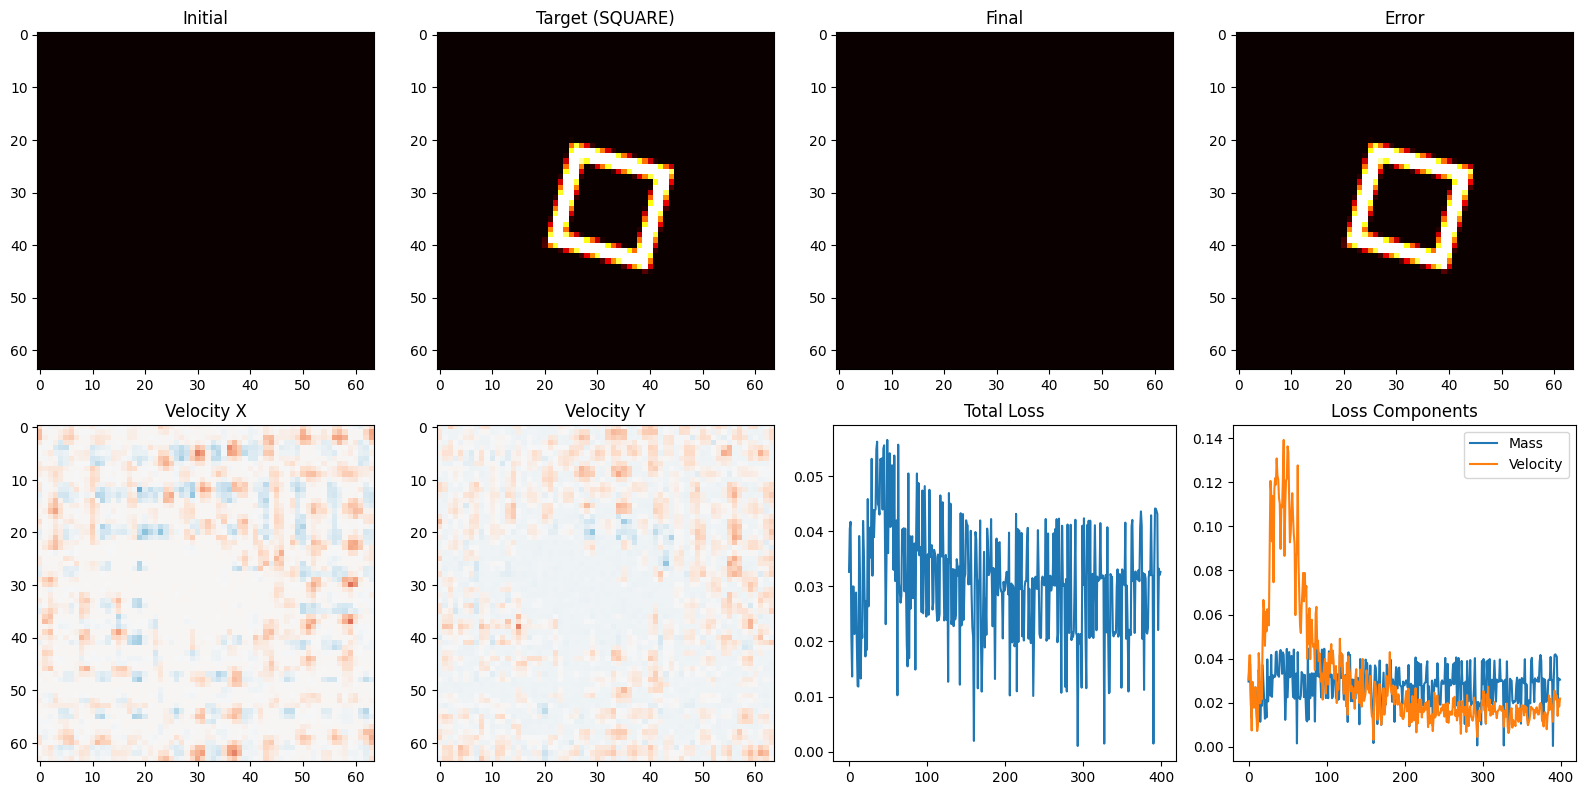


Transitions at epoch 400 (512 steps):


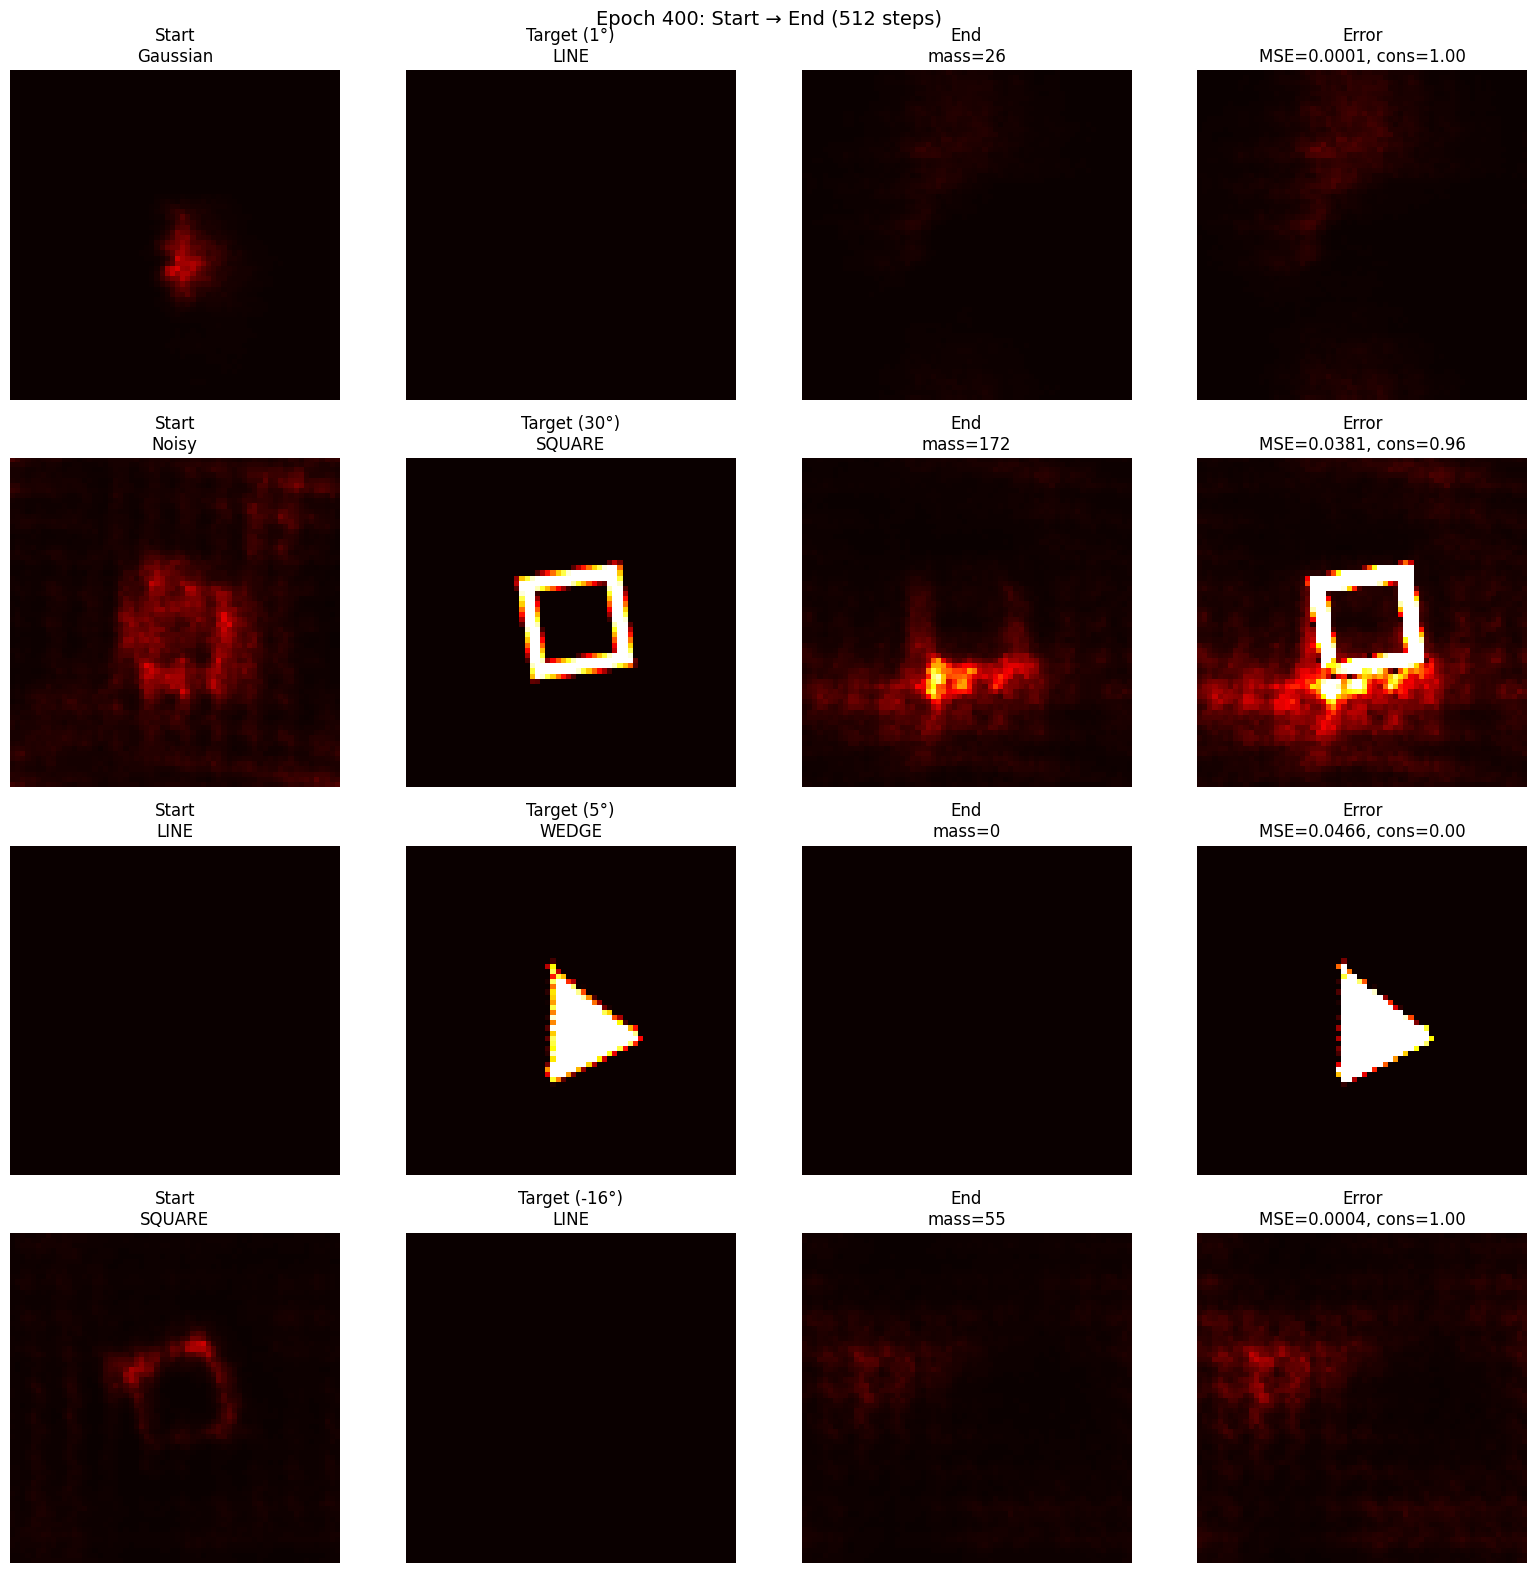

Epoch  450 | Loss: 0.0221 | Mass: 0.0210 | Vel: 0.0116 | Conserv: 1.000
Epoch  500 | Loss: 0.0220 | Mass: 0.0207 | Vel: 0.0127 | Conserv: 1.000
Epoch  550 | Loss: 0.0321 | Mass: 0.0304 | Vel: 0.0174 | Conserv: 1.000
Epoch  600 | Loss: 0.0213 | Mass: 0.0204 | Vel: 0.0085 | Conserv: 0.990
Epoch  650 | Loss: 0.0221 | Mass: 0.0208 | Vel: 0.0127 | Conserv: 1.000
Epoch  700 | Loss: 0.0323 | Mass: 0.0310 | Vel: 0.0130 | Conserv: 1.000
Epoch  750 | Loss: 0.0334 | Mass: 0.0319 | Vel: 0.0145 | Conserv: 1.000
Epoch  800 | Loss: 0.0212 | Mass: 0.0205 | Vel: 0.0078 | Conserv: 1.000


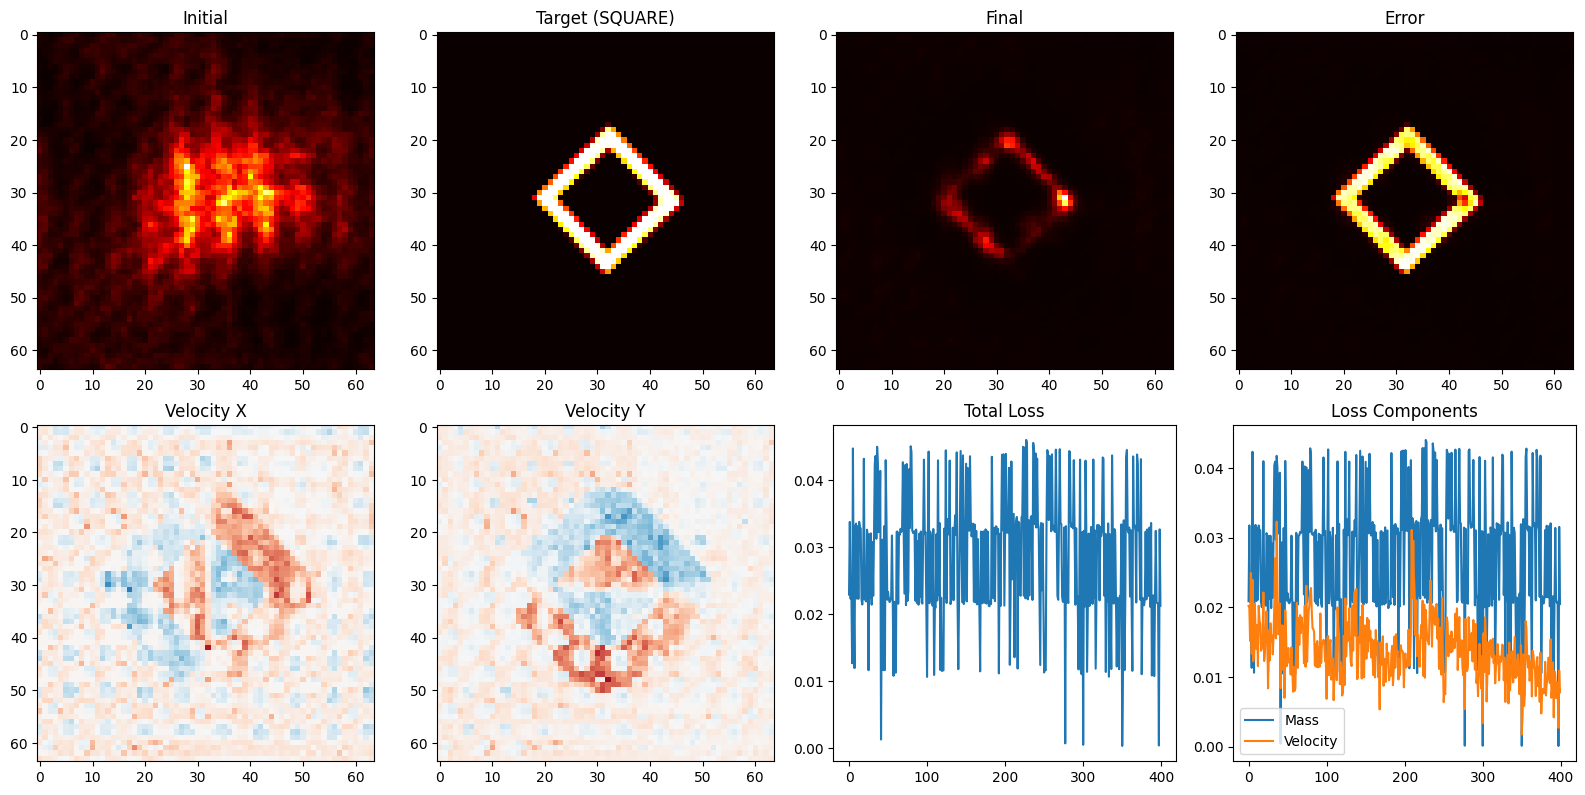


Transitions at epoch 800 (512 steps):


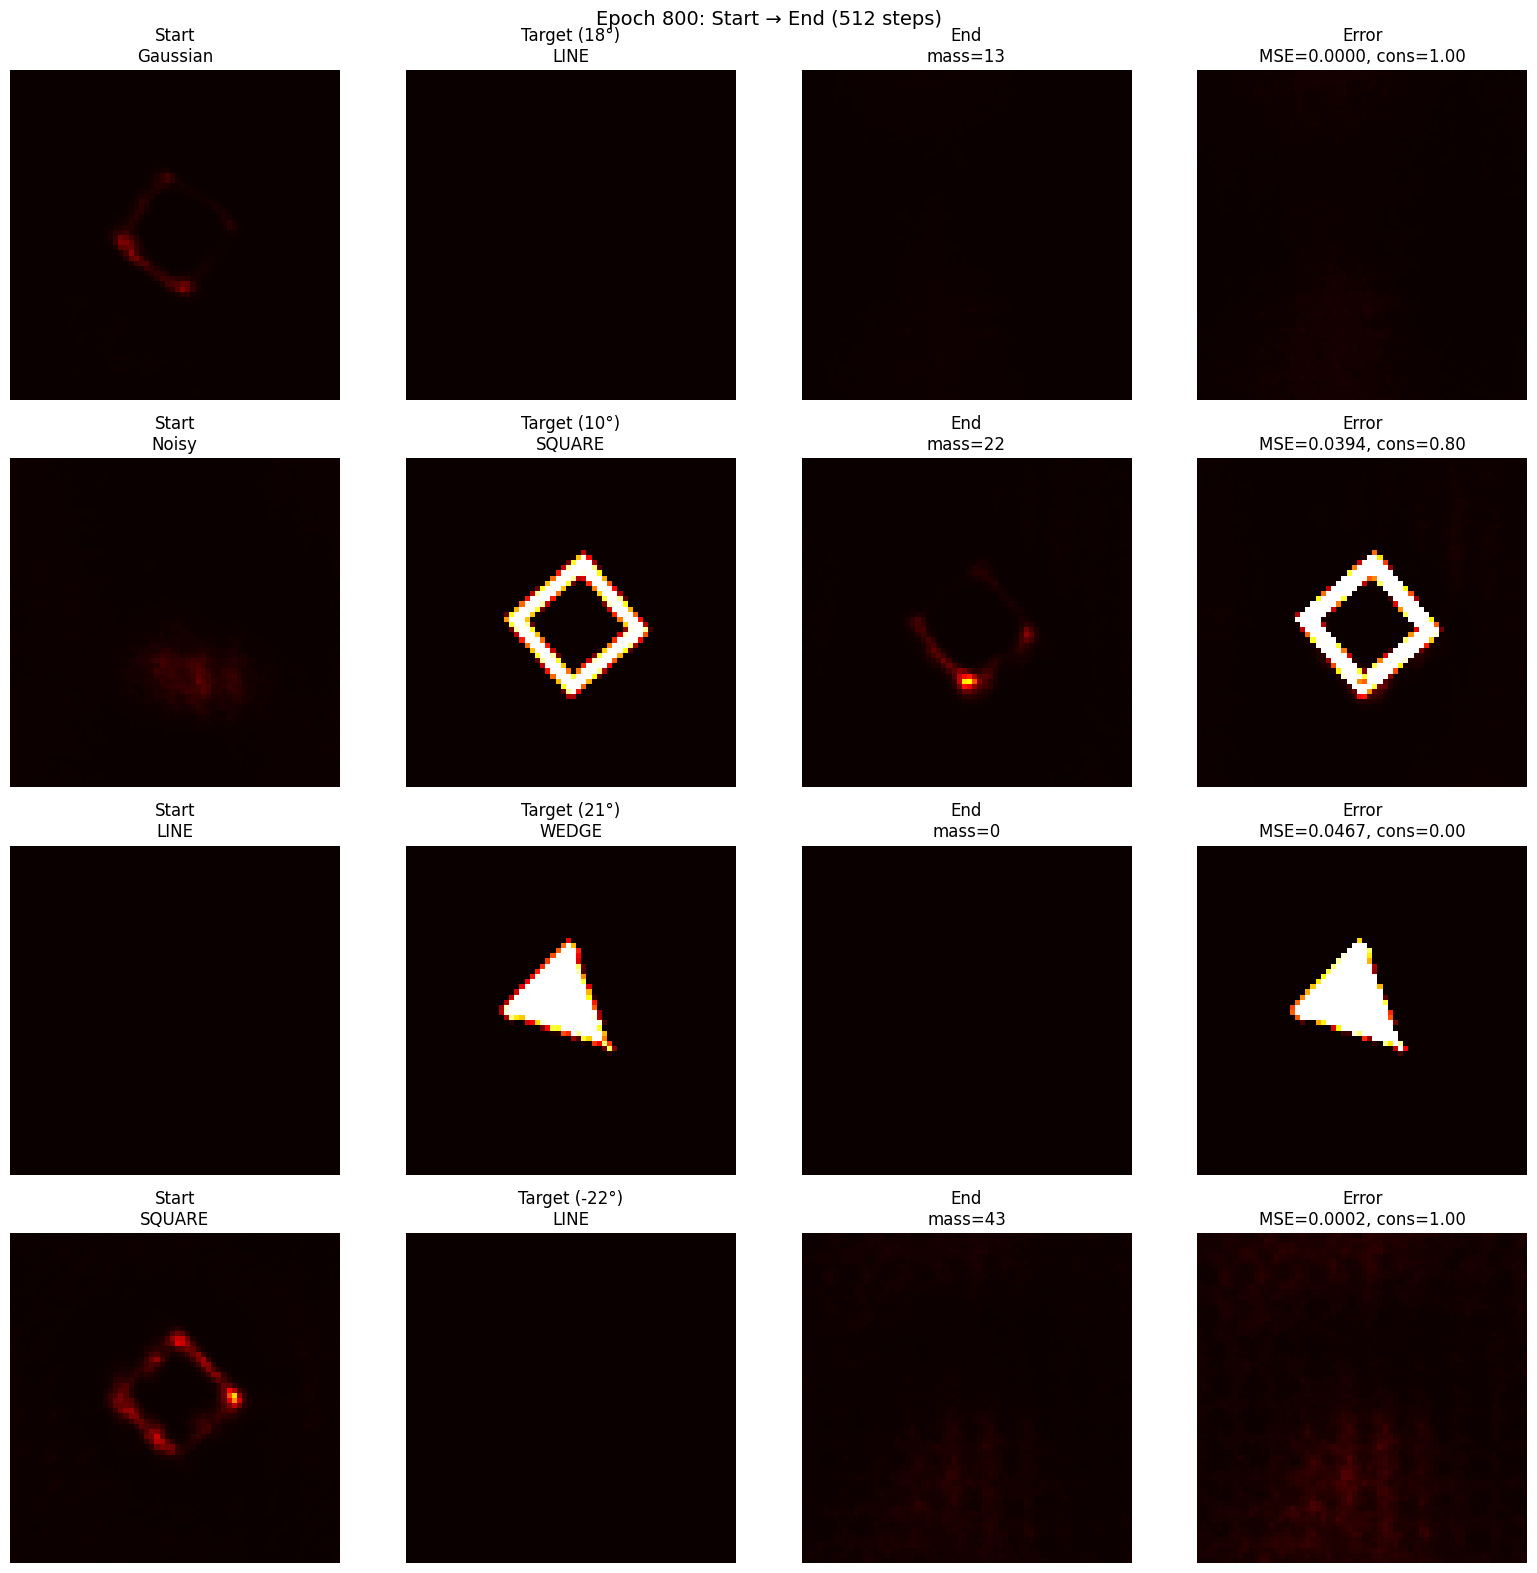

Epoch  850 | Loss: 0.0339 | Mass: 0.0329 | Vel: 0.0103 | Conserv: 1.000
Epoch  900 | Loss: 0.0226 | Mass: 0.0218 | Vel: 0.0085 | Conserv: 0.997
Epoch  950 | Loss: 0.0219 | Mass: 0.0212 | Vel: 0.0070 | Conserv: 1.000
Epoch 1000 | Loss: 0.0217 | Mass: 0.0208 | Vel: 0.0090 | Conserv: 1.000
Epoch 1050 | Loss: 0.0452 | Mass: 0.0440 | Vel: 0.0124 | Conserv: 1.000
Epoch 1100 | Loss: 0.0109 | Mass: 0.0105 | Vel: 0.0039 | Conserv: 0.998
Epoch 1150 | Loss: 0.0114 | Mass: 0.0111 | Vel: 0.0037 | Conserv: 1.000
Epoch 1200 | Loss: 0.0327 | Mass: 0.0317 | Vel: 0.0102 | Conserv: 0.000


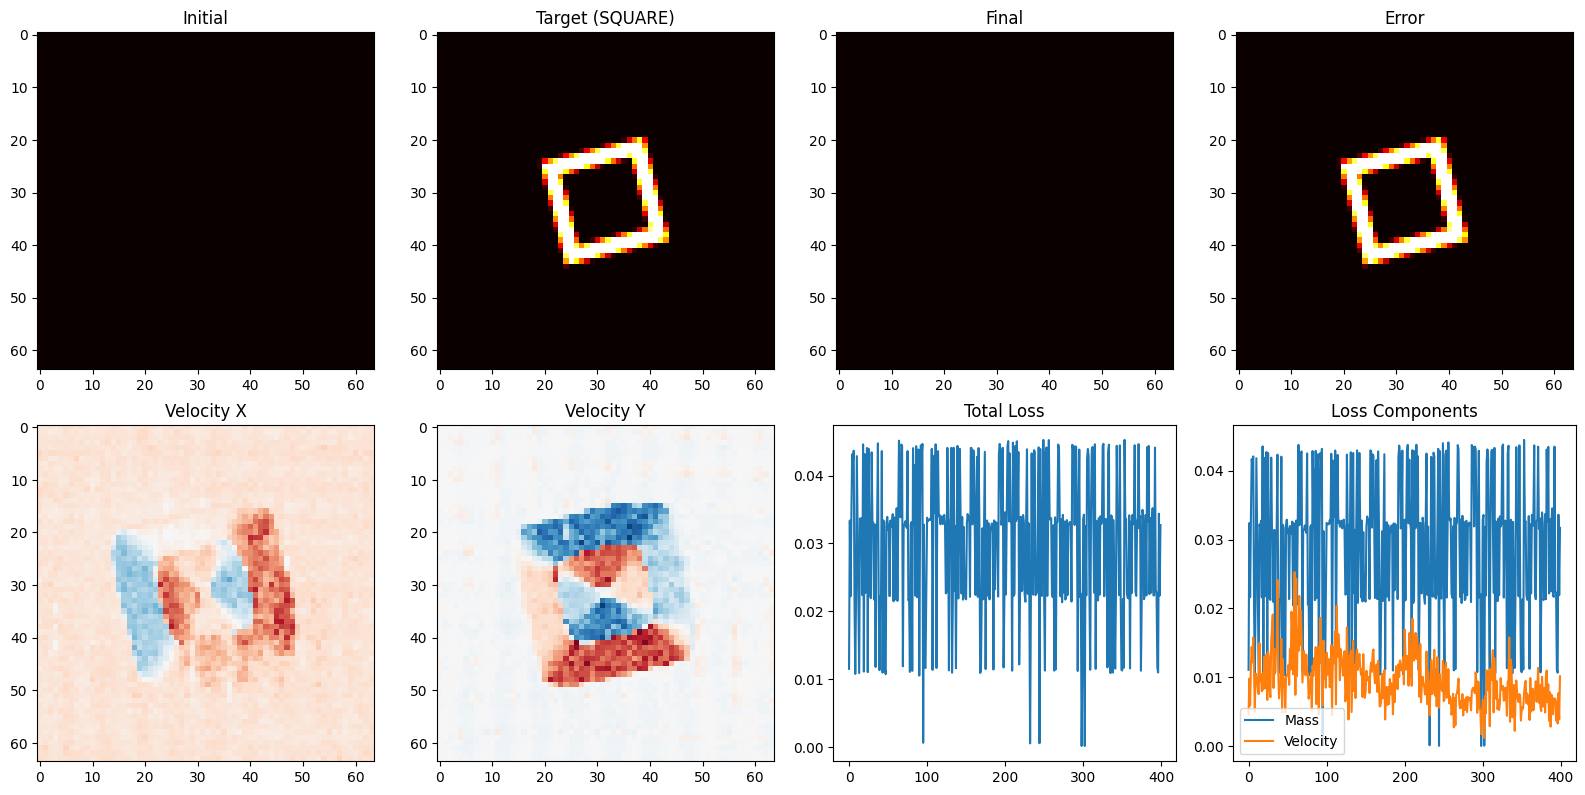


Transitions at epoch 1200 (512 steps):


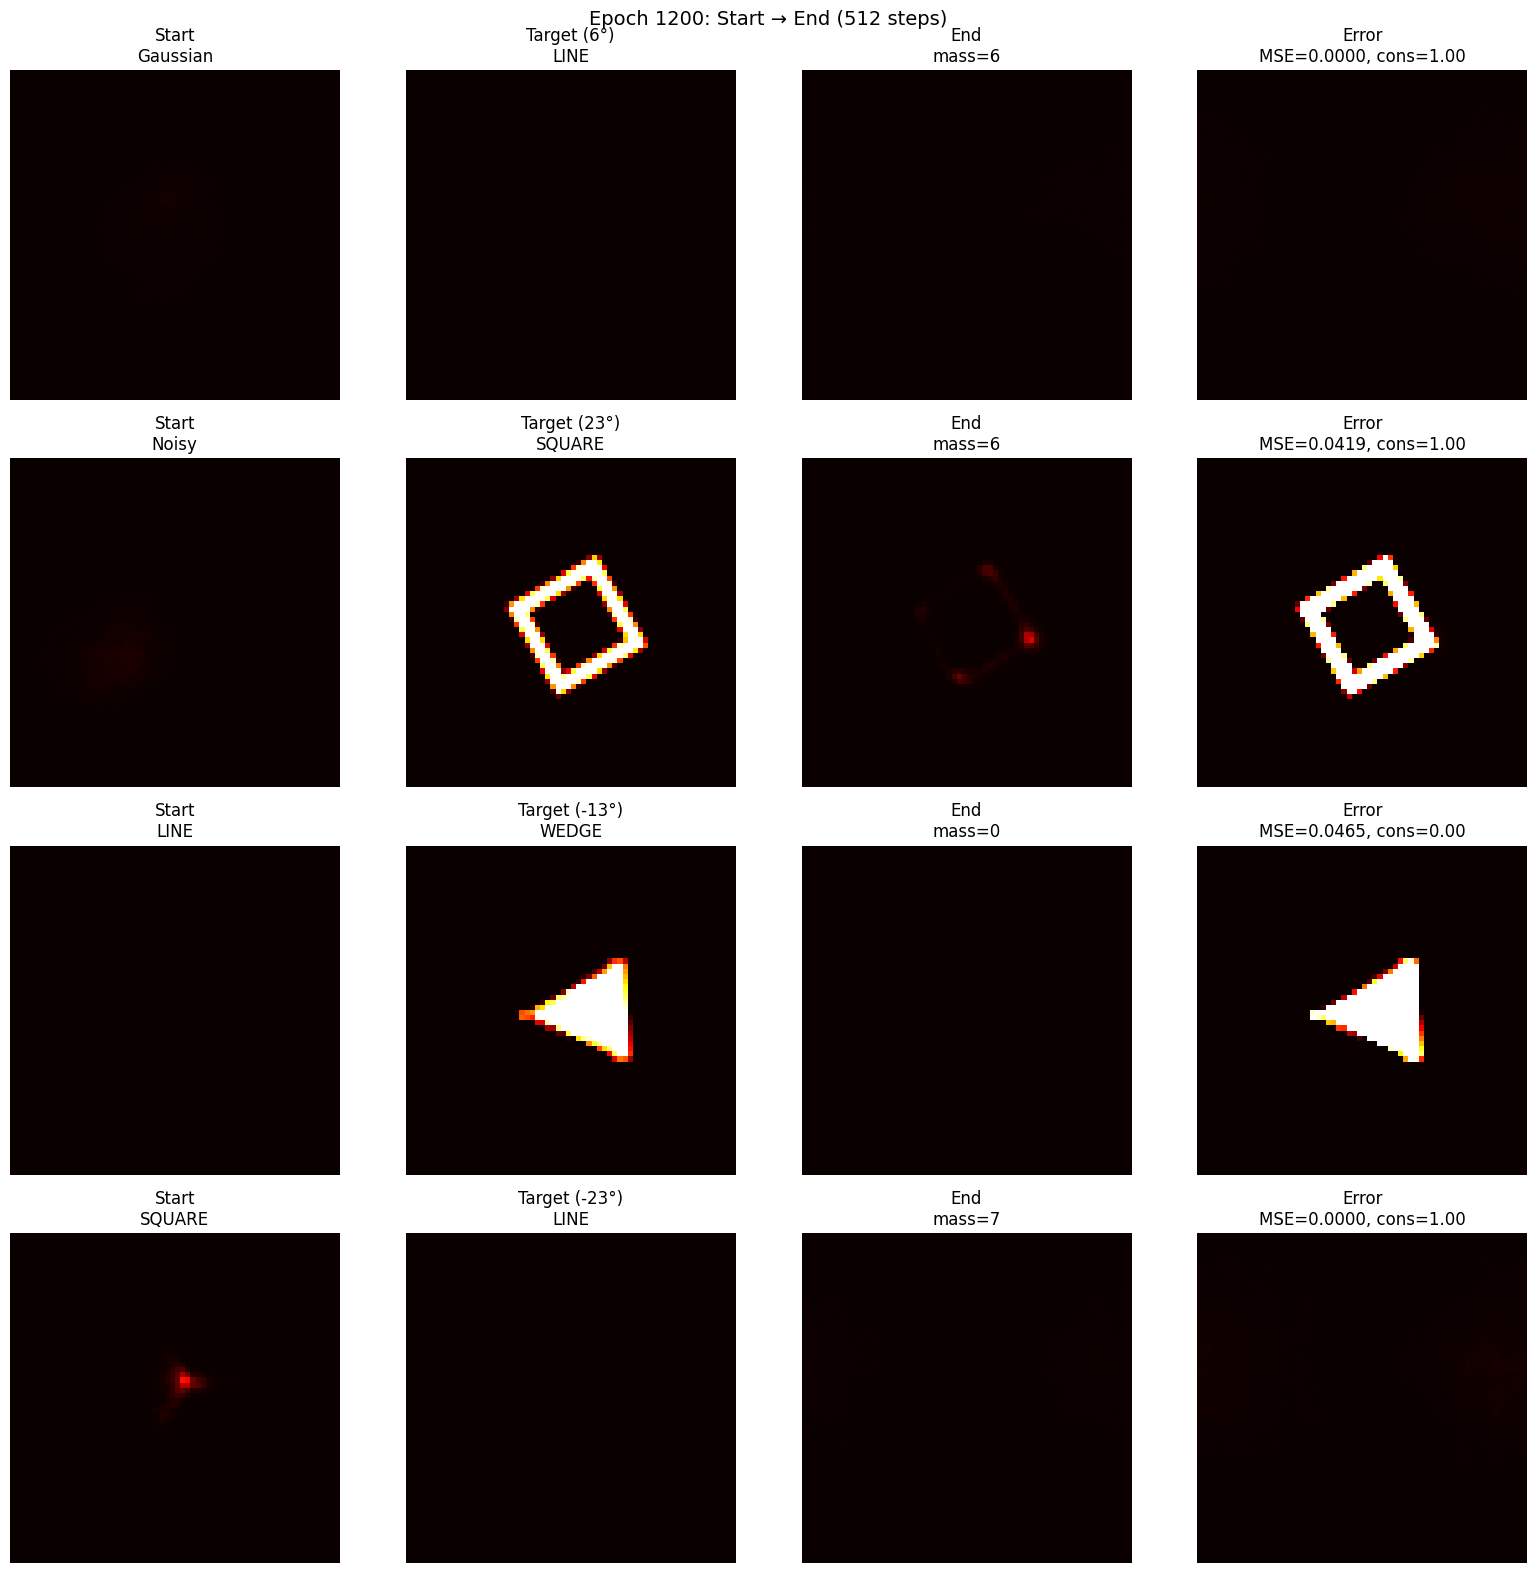

Epoch 1250 | Loss: 0.0338 | Mass: 0.0330 | Vel: 0.0079 | Conserv: 0.000
Epoch 1300 | Loss: 0.0457 | Mass: 0.0452 | Vel: 0.0051 | Conserv: 1.000
Epoch 1350 | Loss: 0.0116 | Mass: 0.0113 | Vel: 0.0026 | Conserv: 1.000
Epoch 1400 | Loss: 0.0471 | Mass: 0.0445 | Vel: 0.0265 | Conserv: 1.000
Epoch 1450 | Loss: 0.0236 | Mass: 0.0230 | Vel: 0.0056 | Conserv: 1.000
Epoch 1500 | Loss: 0.0358 | Mass: 0.0346 | Vel: 0.0124 | Conserv: 1.000
Epoch 1550 | Loss: 0.0346 | Mass: 0.0337 | Vel: 0.0089 | Conserv: 1.000
Epoch 1600 | Loss: 0.0224 | Mass: 0.0215 | Vel: 0.0087 | Conserv: 1.000


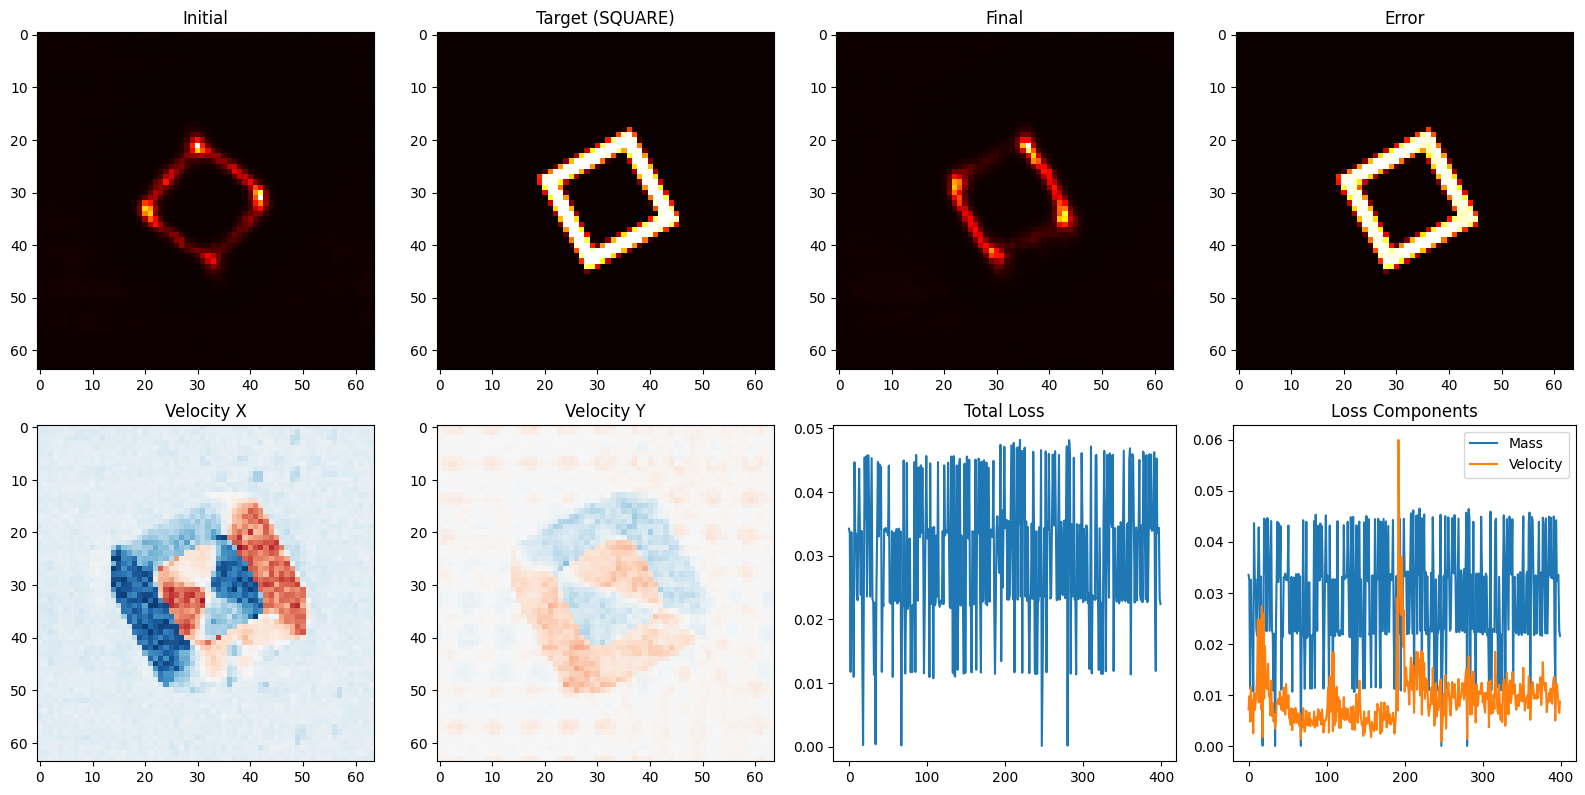


Transitions at epoch 1600 (512 steps):


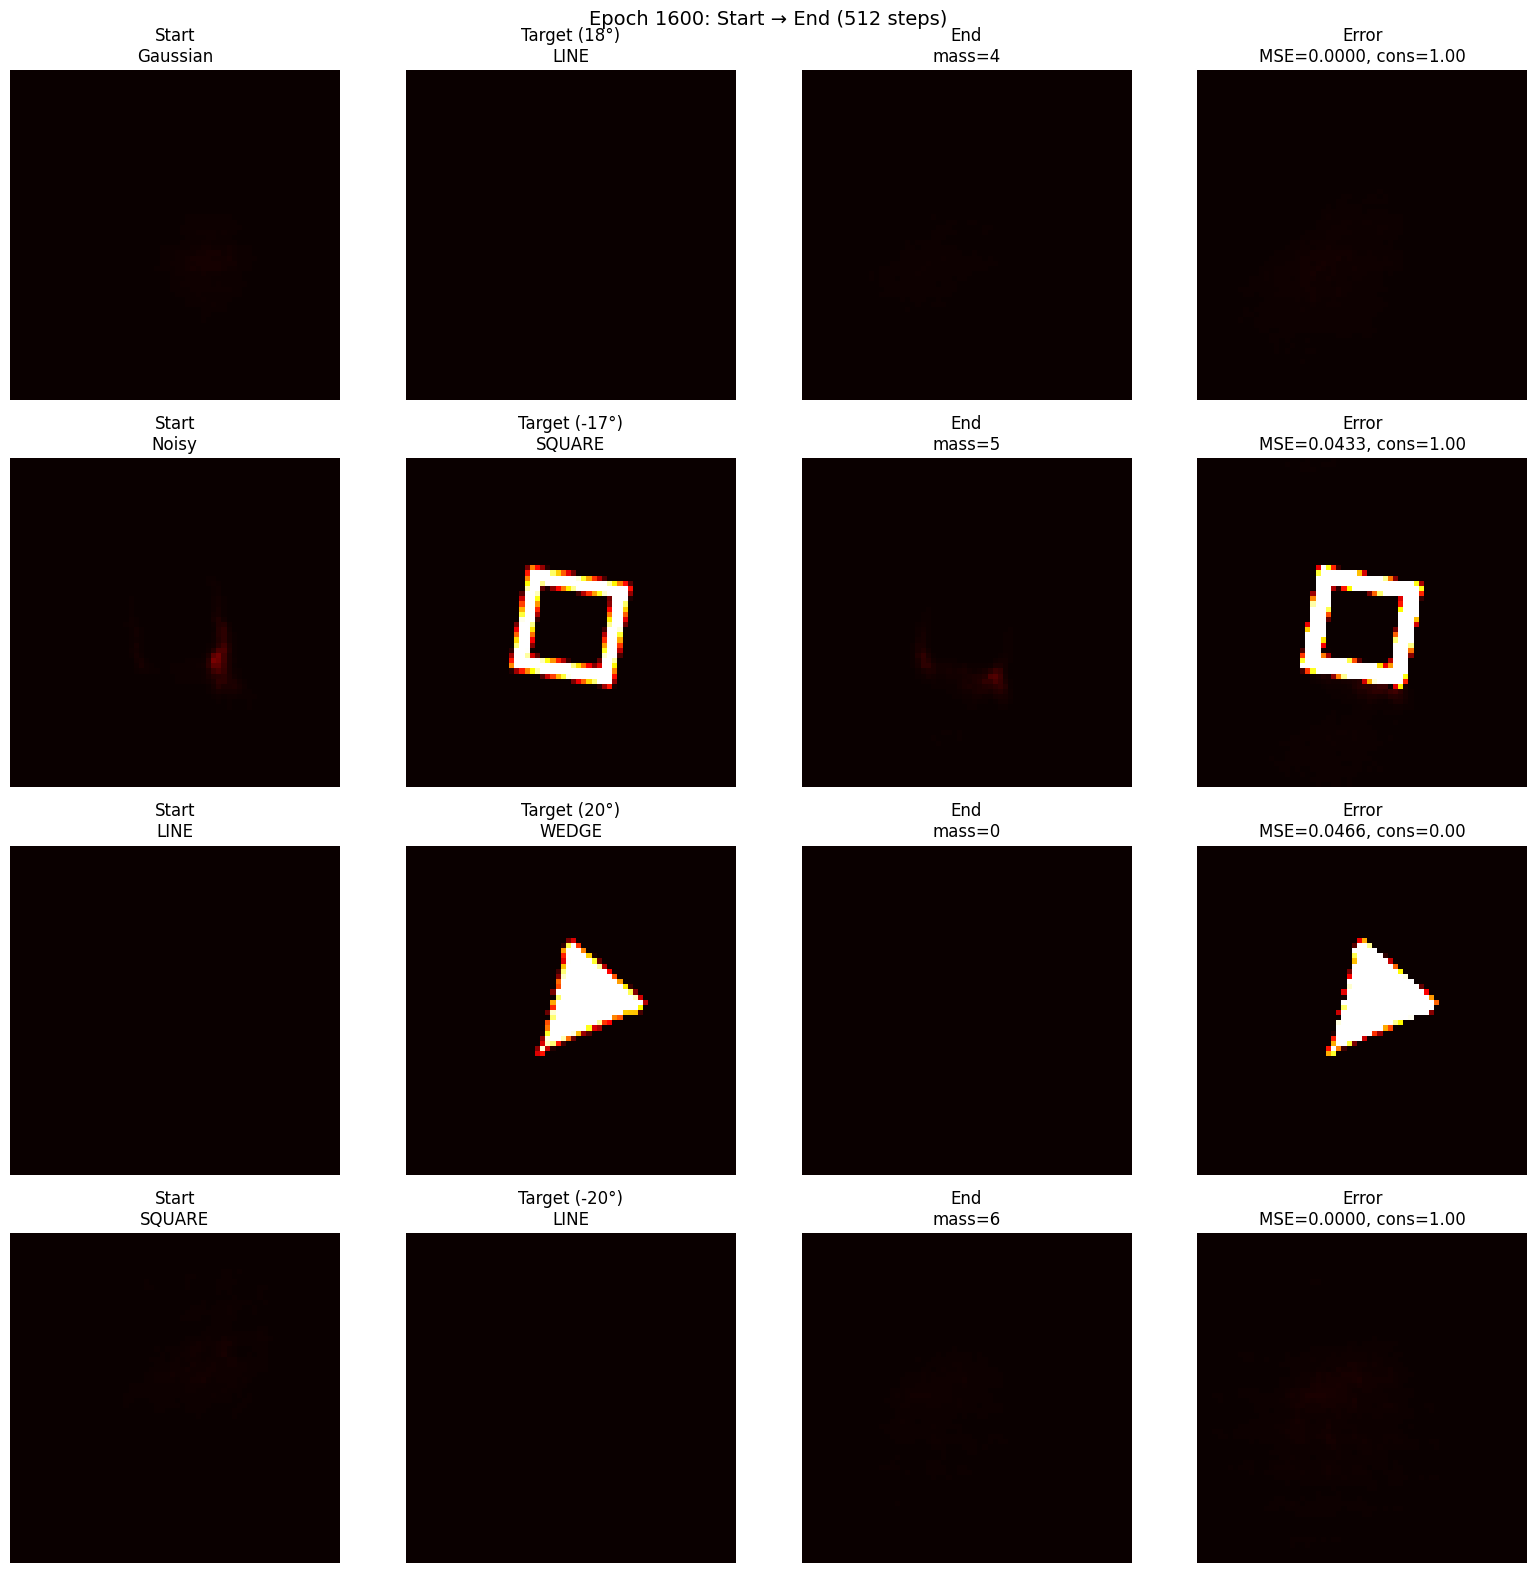

Epoch 1650 | Loss: 0.0237 | Mass: 0.0226 | Vel: 0.0109 | Conserv: 1.000
Epoch 1700 | Loss: 0.0341 | Mass: 0.0330 | Vel: 0.0103 | Conserv: 1.000
Epoch 1750 | Loss: 0.0448 | Mass: 0.0435 | Vel: 0.0133 | Conserv: 1.000
Epoch 1800 | Loss: 0.0354 | Mass: 0.0337 | Vel: 0.0168 | Conserv: 0.000
Epoch 1850 | Loss: 0.0353 | Mass: 0.0337 | Vel: 0.0161 | Conserv: 0.000
Epoch 1900 | Loss: 0.0353 | Mass: 0.0337 | Vel: 0.0161 | Conserv: 0.000
Epoch 1950 | Loss: 0.0350 | Mass: 0.0332 | Vel: 0.0182 | Conserv: 0.000
Epoch 2000 | Loss: 0.0357 | Mass: 0.0342 | Vel: 0.0147 | Conserv: 1.000


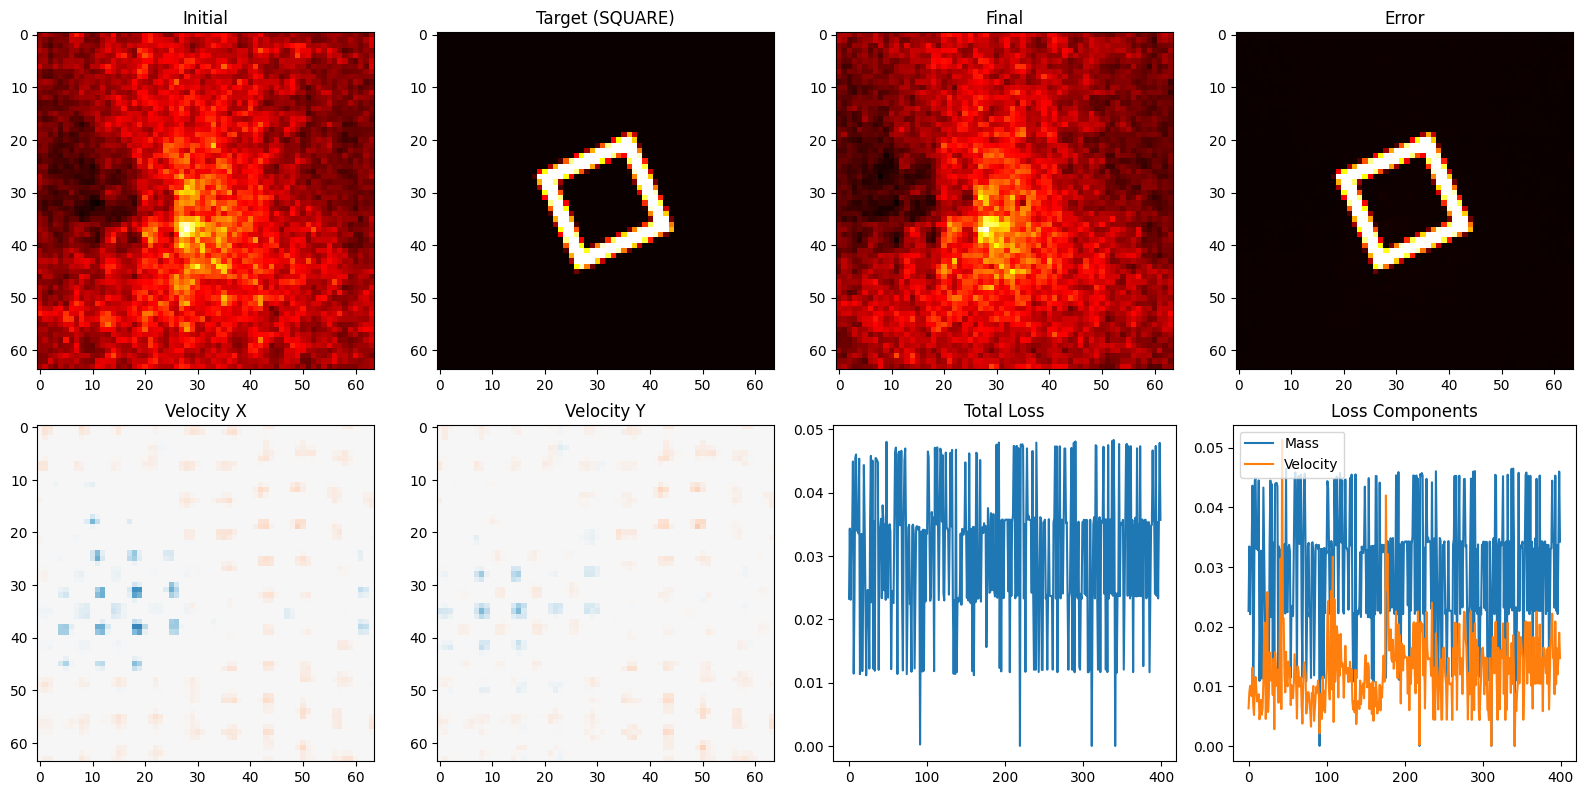


Transitions at epoch 2000 (512 steps):


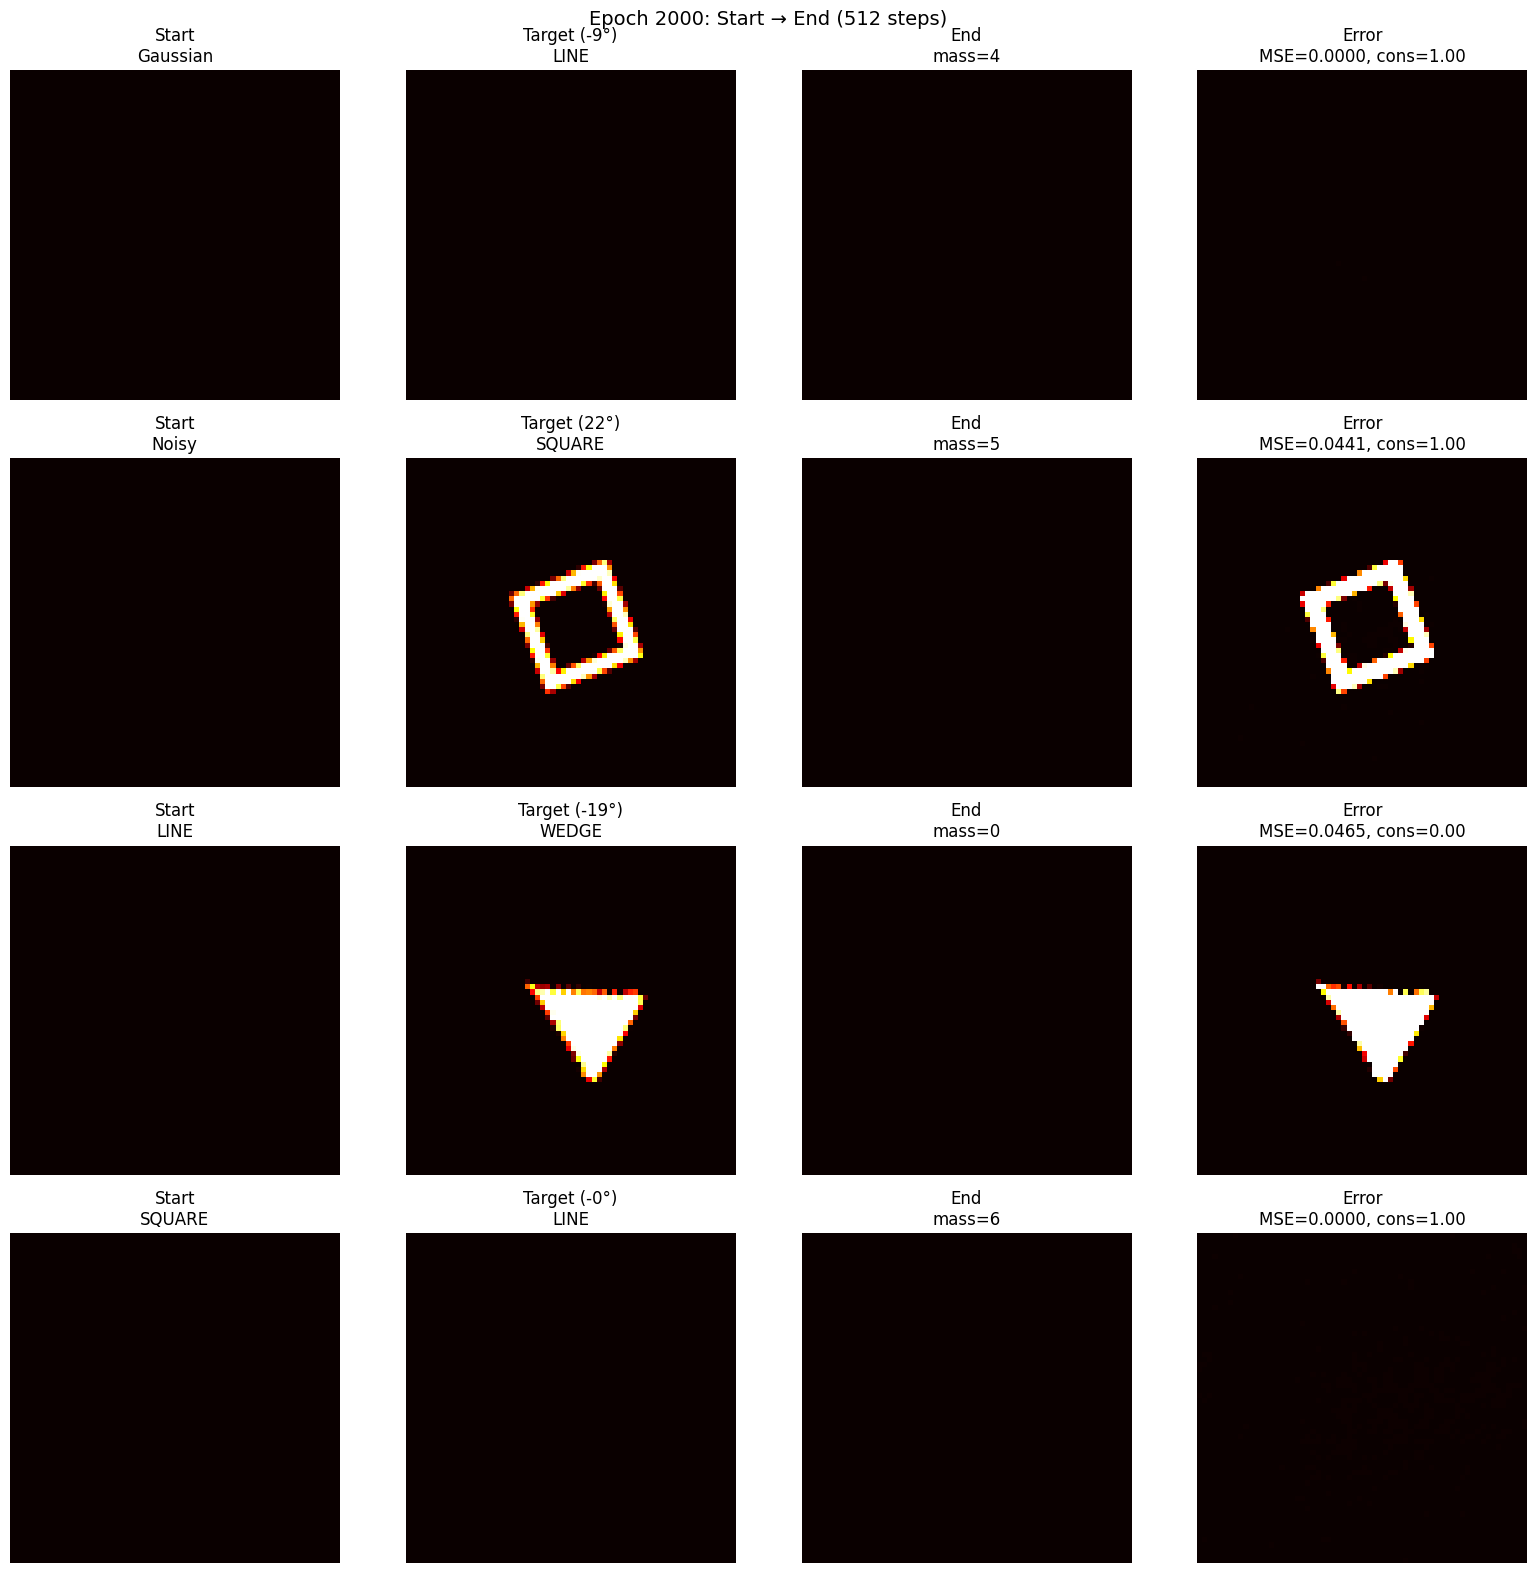

Epoch 2050 | Loss: 0.0361 | Mass: 0.0348 | Vel: 0.0130 | Conserv: 1.000
Epoch 2100 | Loss: 0.0358 | Mass: 0.0342 | Vel: 0.0163 | Conserv: 1.000
Epoch 2150 | Loss: 0.0354 | Mass: 0.0337 | Vel: 0.0166 | Conserv: 1.000
Epoch 2200 | Loss: 0.0000 | Mass: 0.0000 | Vel: 0.0002 | Conserv: 1.000
Epoch 2250 | Loss: 0.0240 | Mass: 0.0232 | Vel: 0.0088 | Conserv: 1.000
Epoch 2300 | Loss: 0.0241 | Mass: 0.0232 | Vel: 0.0087 | Conserv: 1.000
Epoch 2350 | Loss: 0.0474 | Mass: 0.0453 | Vel: 0.0206 | Conserv: 1.000
Epoch 2400 | Loss: 0.0473 | Mass: 0.0452 | Vel: 0.0207 | Conserv: 0.000


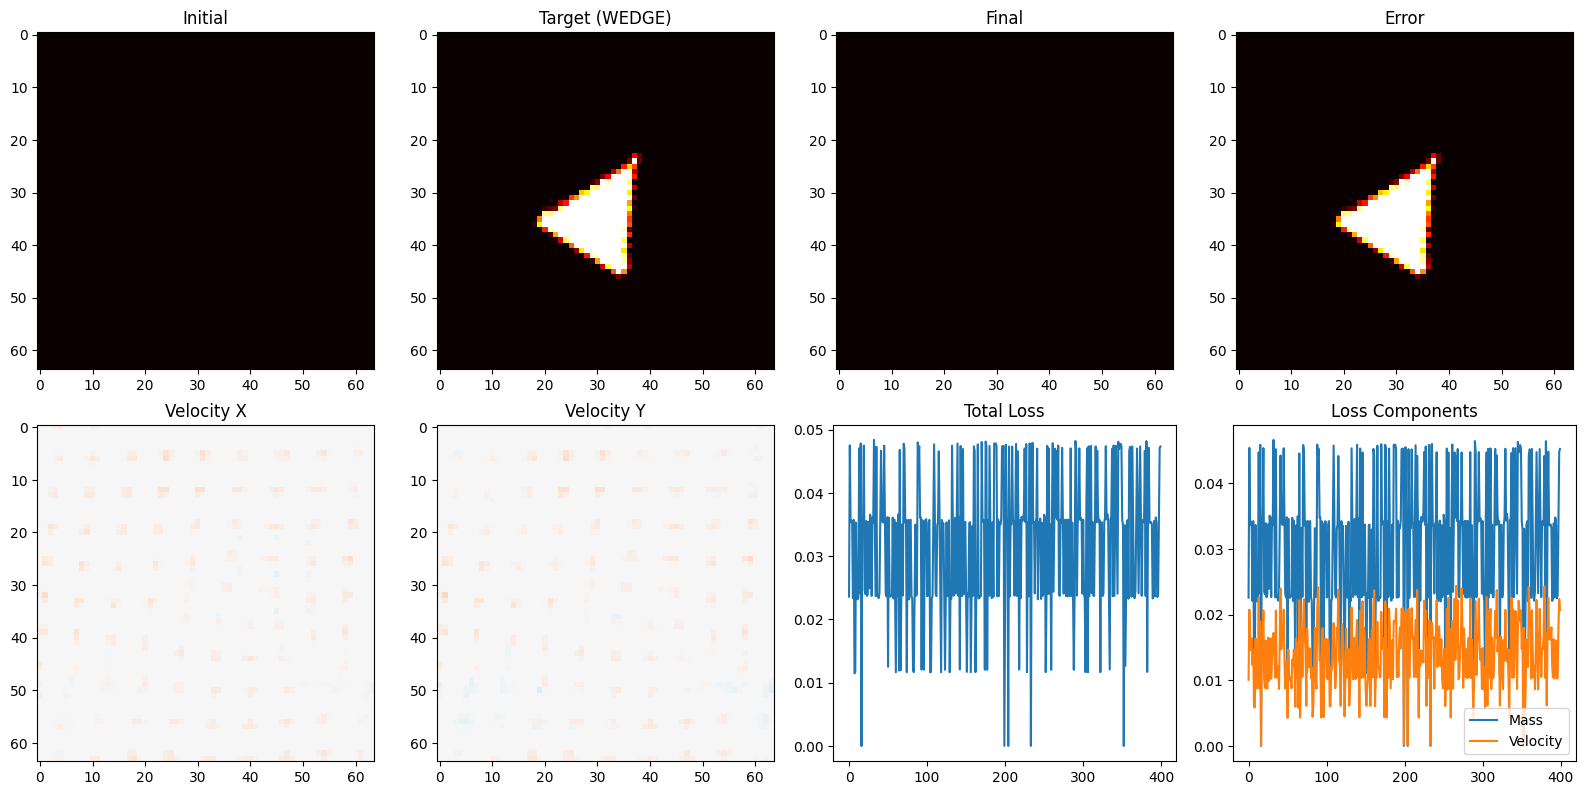


Transitions at epoch 2400 (512 steps):


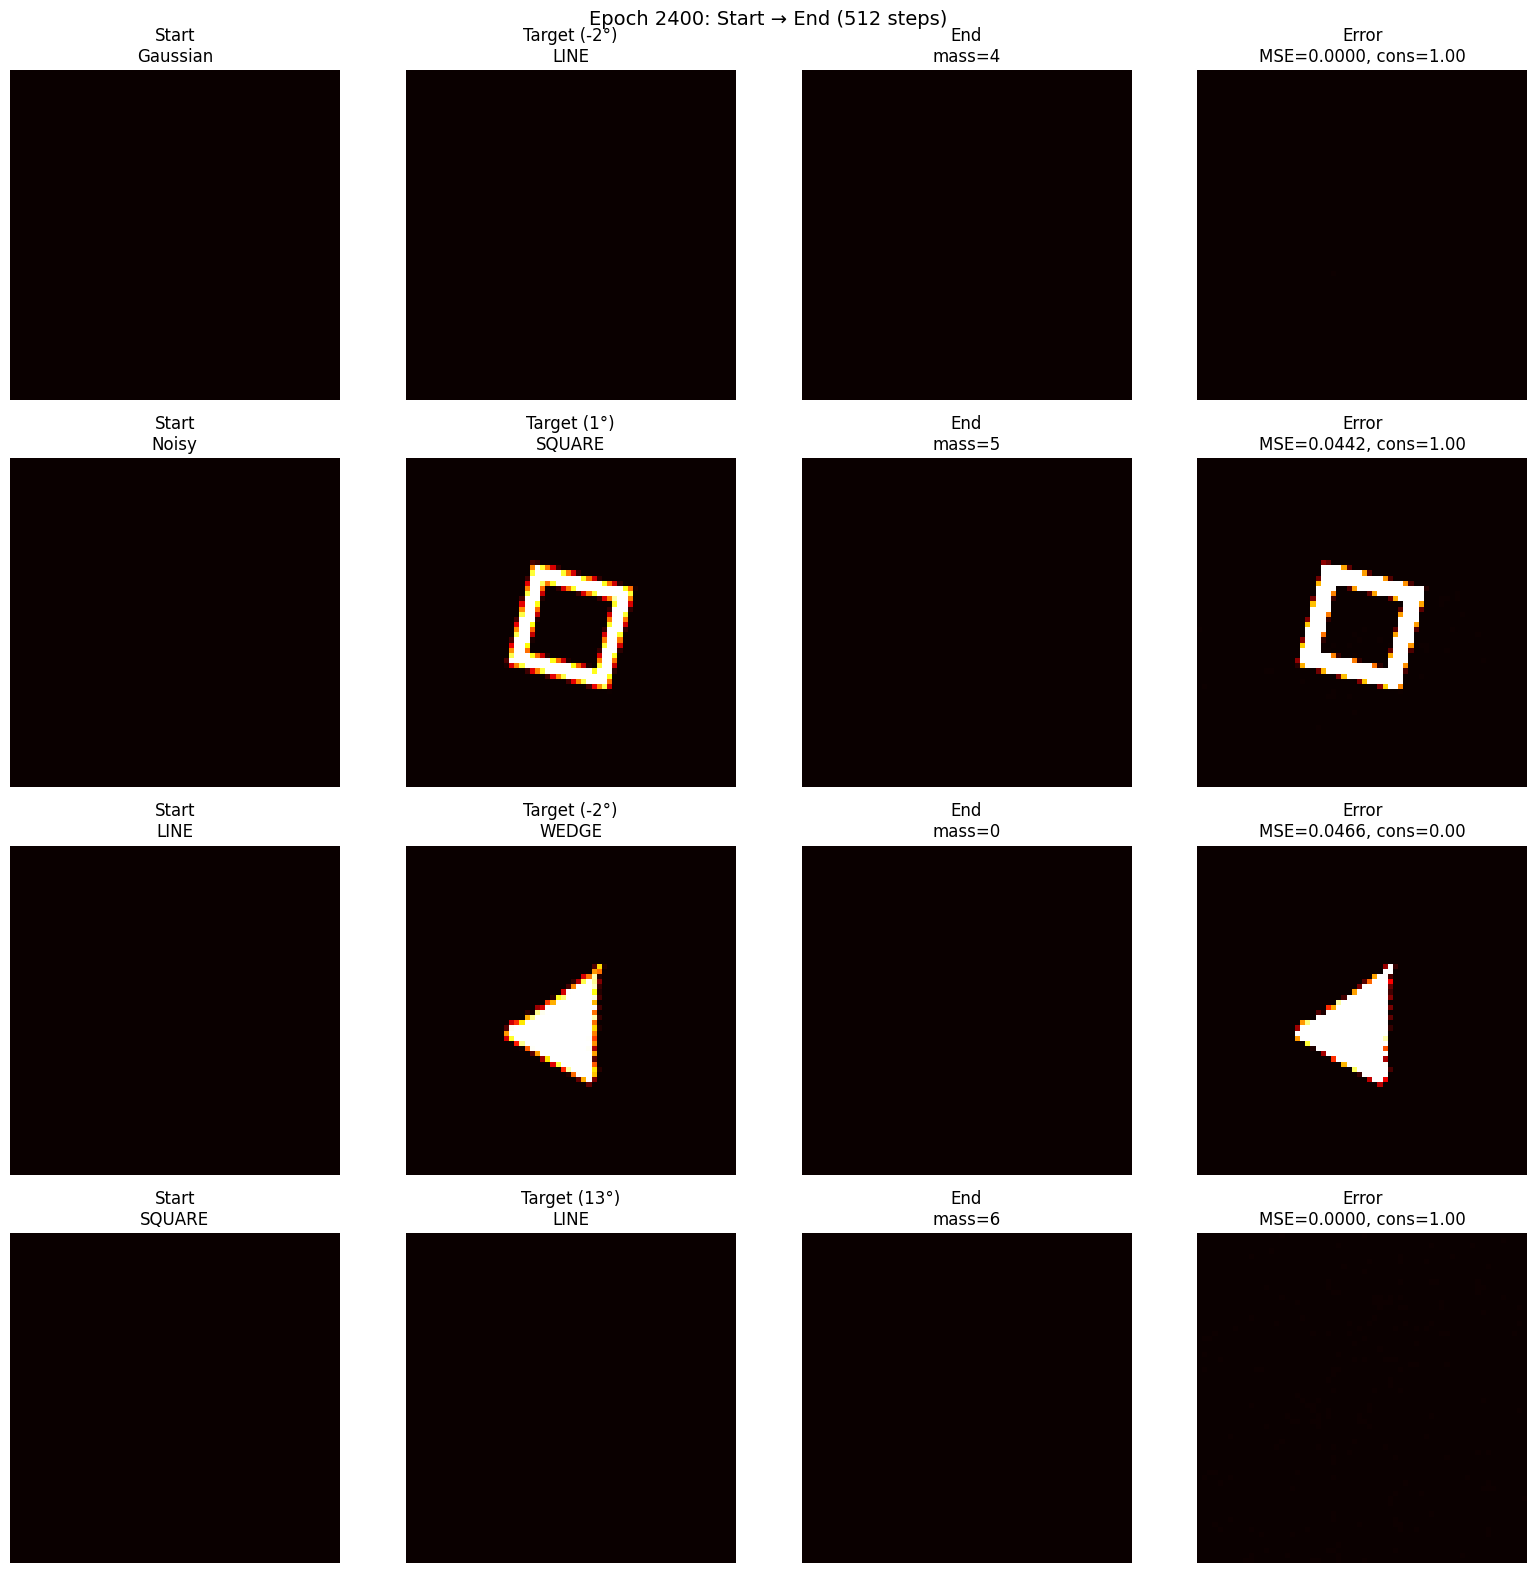

Epoch 2450 | Loss: 0.0236 | Mass: 0.0226 | Vel: 0.0102 | Conserv: 0.000
Epoch 2500 | Loss: 0.0466 | Mass: 0.0442 | Vel: 0.0242 | Conserv: 1.000
Epoch 2550 | Loss: 0.0242 | Mass: 0.0233 | Vel: 0.0090 | Conserv: 1.000
Epoch 2600 | Loss: 0.0357 | Mass: 0.0342 | Vel: 0.0147 | Conserv: 1.000
Epoch 2650 | Loss: 0.0474 | Mass: 0.0453 | Vel: 0.0209 | Conserv: 1.000
Epoch 2700 | Loss: 0.0241 | Mass: 0.0232 | Vel: 0.0086 | Conserv: 1.000
Epoch 2750 | Loss: 0.0241 | Mass: 0.0232 | Vel: 0.0088 | Conserv: 1.000
Epoch 2800 | Loss: 0.0241 | Mass: 0.0229 | Vel: 0.0118 | Conserv: 1.000


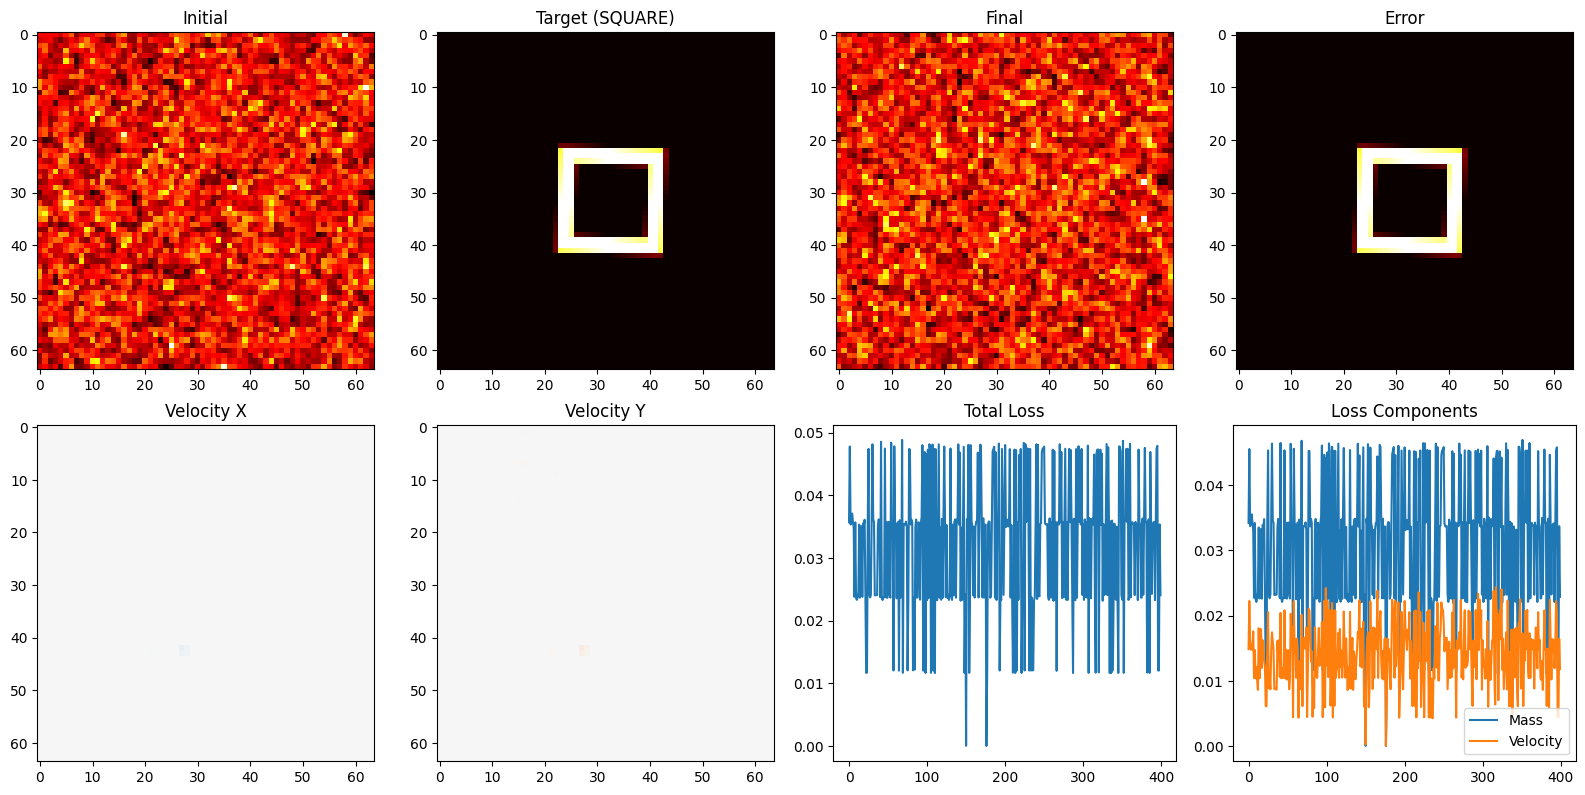


Transitions at epoch 2800 (512 steps):


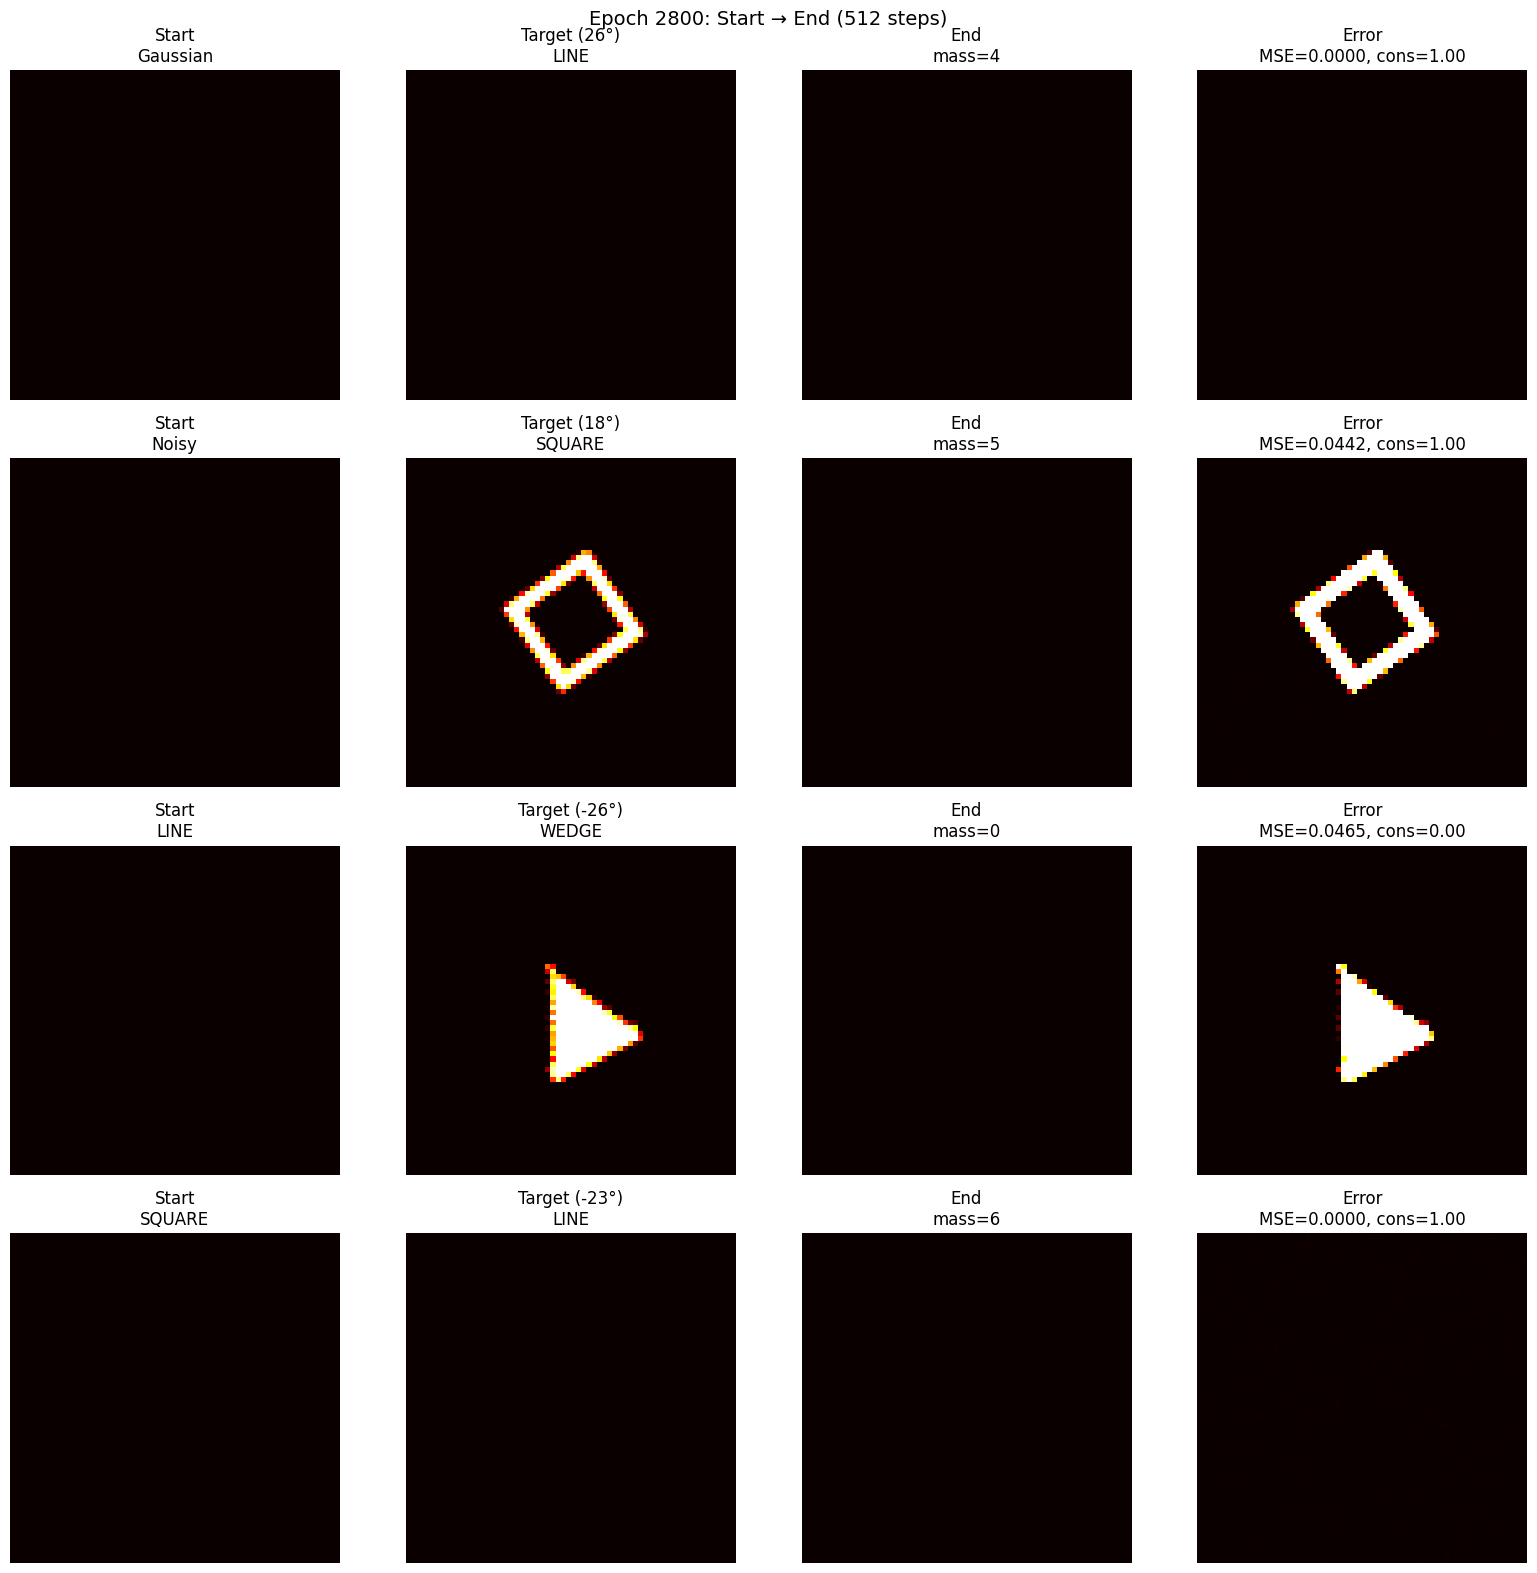

Epoch 2850 | Loss: 0.0357 | Mass: 0.0343 | Vel: 0.0146 | Conserv: 0.000
Epoch 2900 | Loss: 0.0354 | Mass: 0.0337 | Vel: 0.0166 | Conserv: 1.000
Epoch 2950 | Loss: 0.0237 | Mass: 0.0227 | Vel: 0.0104 | Conserv: 0.000
Epoch 3000 | Loss: 0.0237 | Mass: 0.0226 | Vel: 0.0105 | Conserv: 1.000
Epoch 3050 | Loss: 0.0482 | Mass: 0.0463 | Vel: 0.0191 | Conserv: 1.000
Epoch 3100 | Loss: 0.0352 | Mass: 0.0335 | Vel: 0.0176 | Conserv: 1.000
Epoch 3150 | Loss: 0.0352 | Mass: 0.0335 | Vel: 0.0178 | Conserv: 0.000
Epoch 3200 | Loss: 0.0235 | Mass: 0.0225 | Vel: 0.0102 | Conserv: 0.000


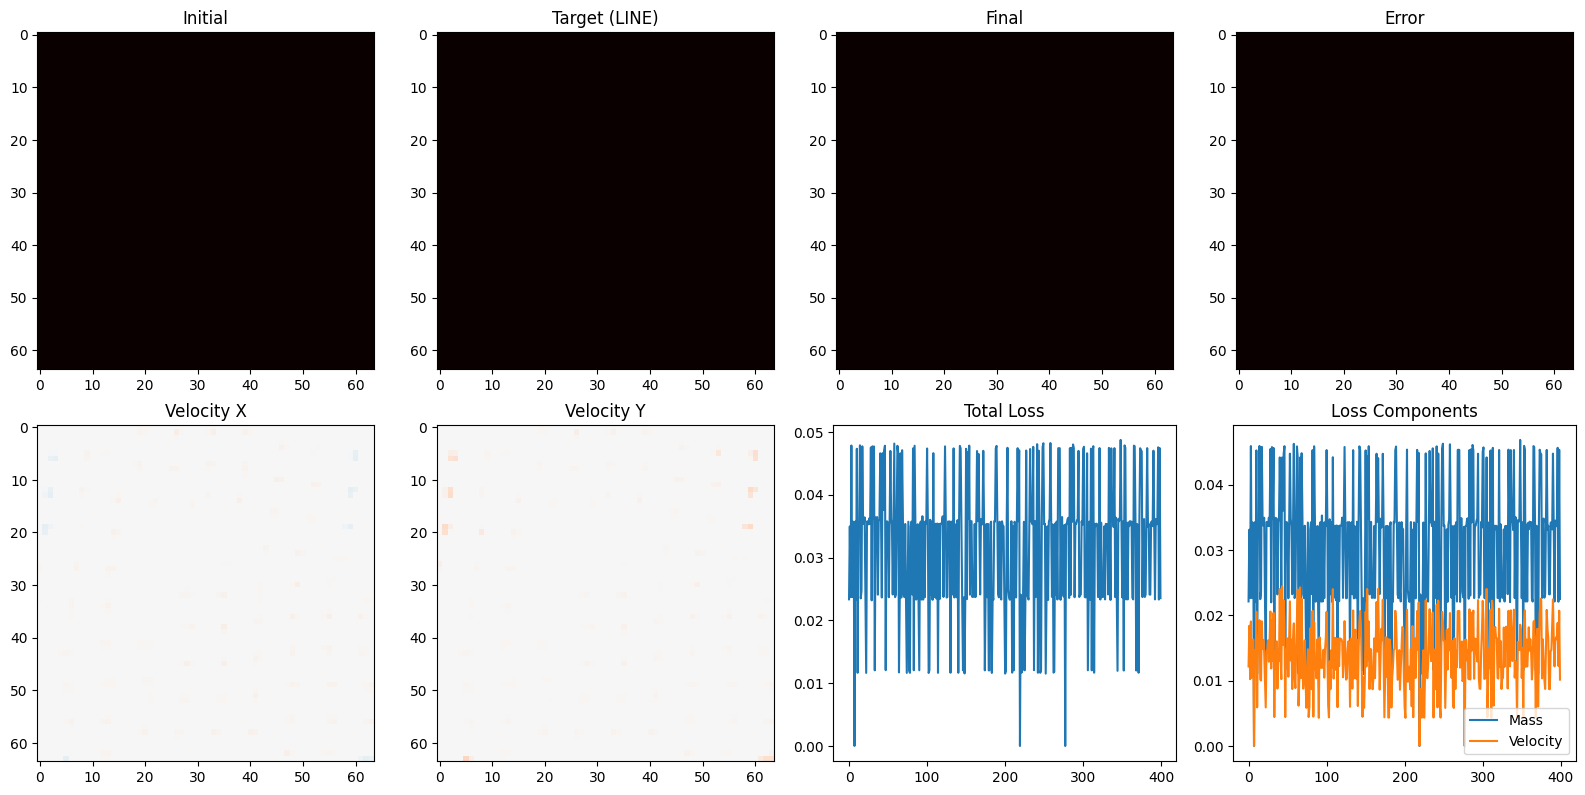


Transitions at epoch 3200 (512 steps):


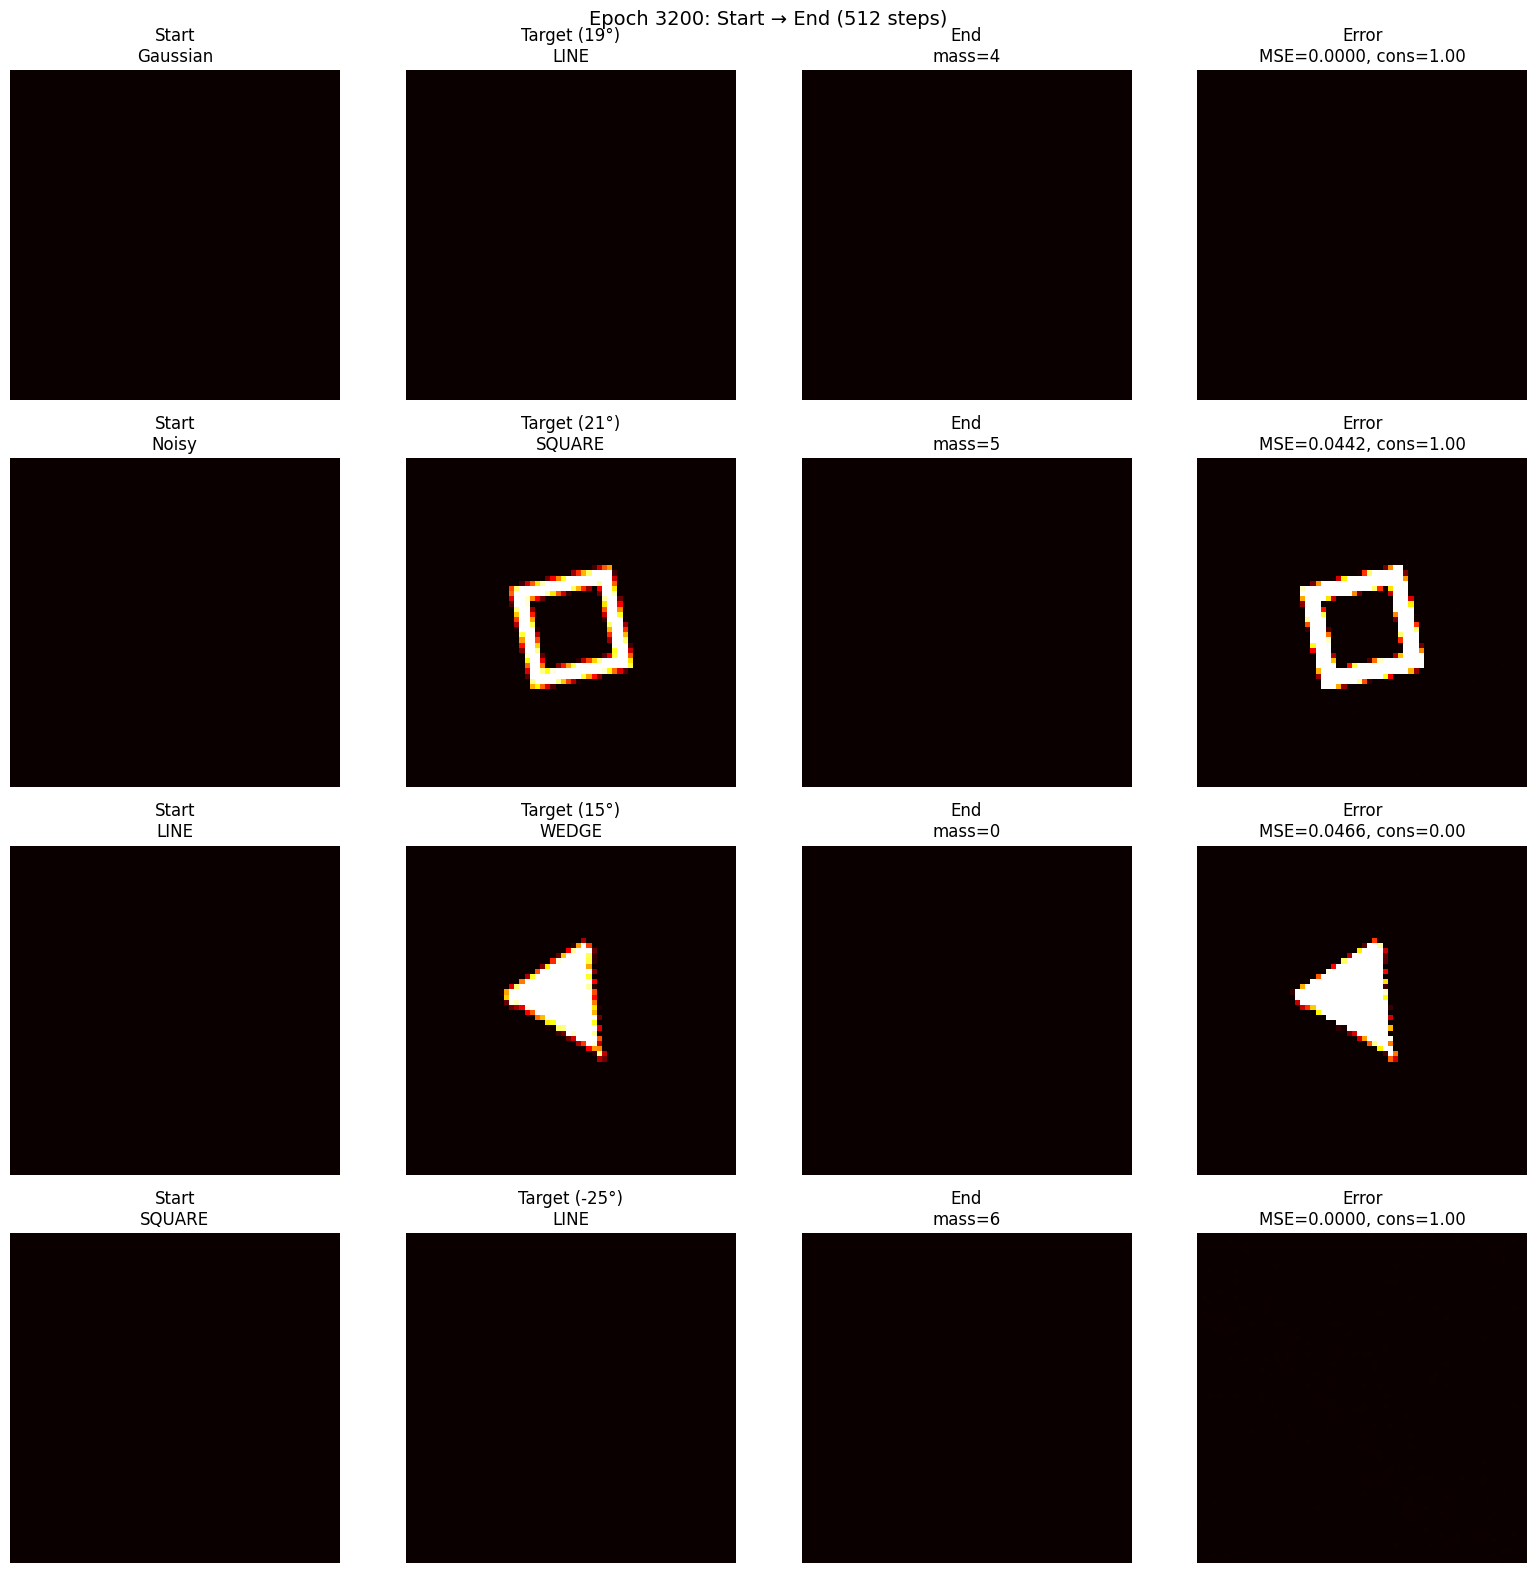

Epoch 3250 | Loss: 0.0362 | Mass: 0.0348 | Vel: 0.0130 | Conserv: 0.000
Epoch 3300 | Loss: 0.0241 | Mass: 0.0233 | Vel: 0.0087 | Conserv: 1.000
Epoch 3350 | Loss: 0.0241 | Mass: 0.0233 | Vel: 0.0088 | Conserv: 0.000
Epoch 3400 | Loss: 0.0479 | Mass: 0.0458 | Vel: 0.0204 | Conserv: 1.000
Epoch 3450 | Loss: 0.0358 | Mass: 0.0344 | Vel: 0.0146 | Conserv: 0.000
Epoch 3500 | Loss: 0.0363 | Mass: 0.0348 | Vel: 0.0144 | Conserv: 1.000
Epoch 3550 | Loss: 0.0353 | Mass: 0.0337 | Vel: 0.0162 | Conserv: 1.000
Epoch 3600 | Loss: 0.0237 | Mass: 0.0227 | Vel: 0.0104 | Conserv: 0.000


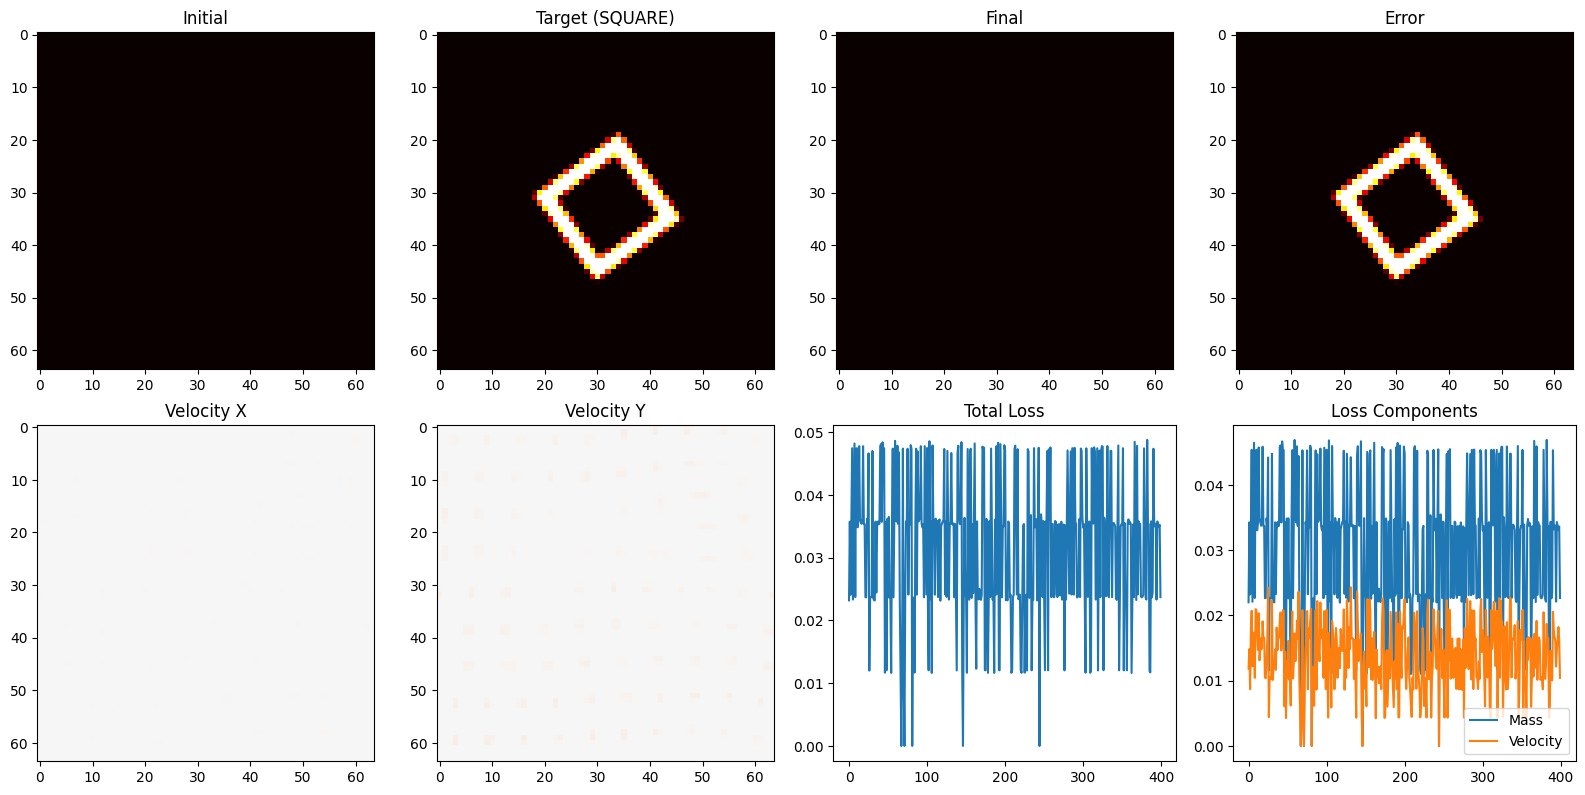


Transitions at epoch 3600 (512 steps):


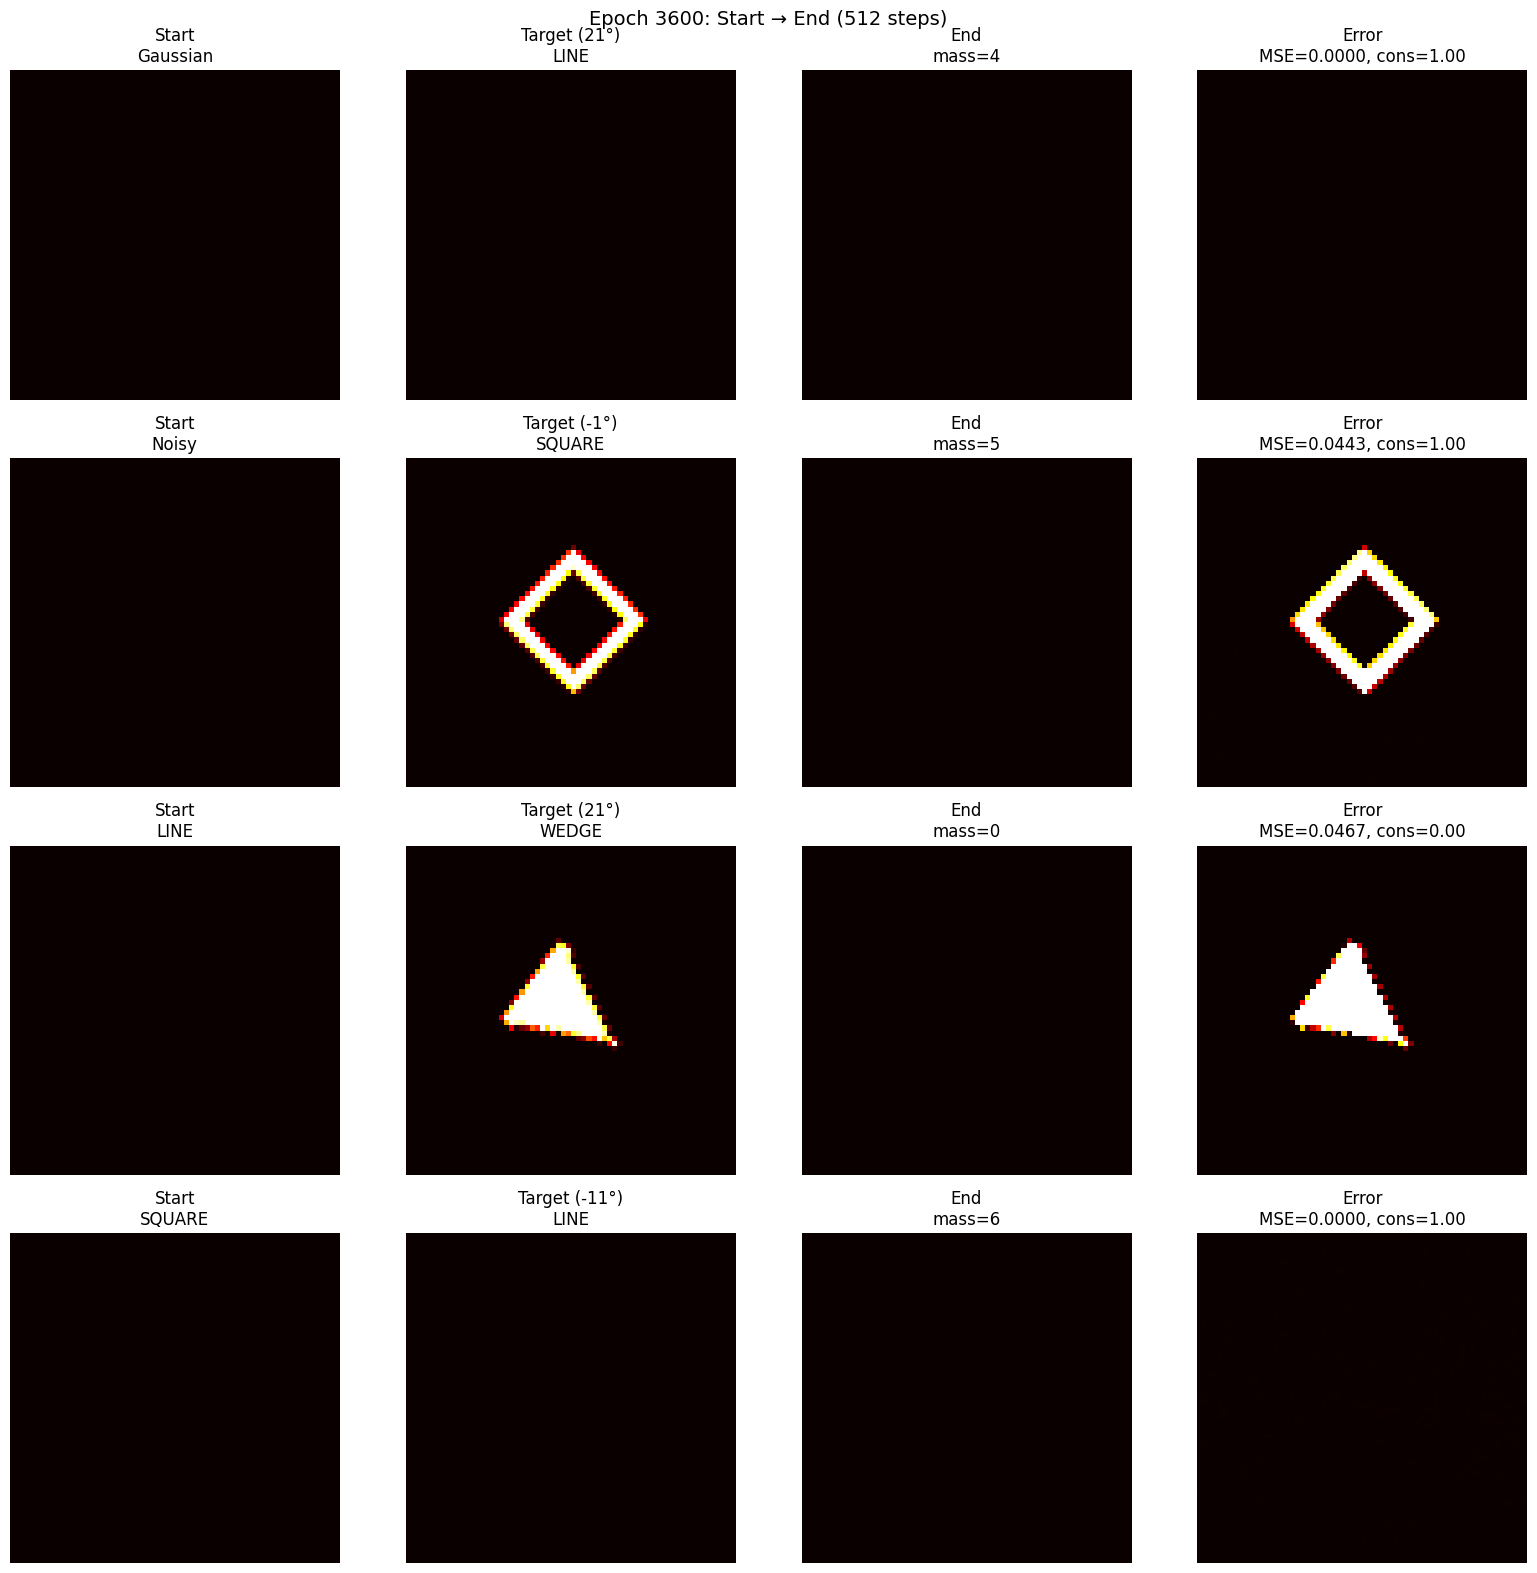

Epoch 3650 | Loss: 0.0353 | Mass: 0.0337 | Vel: 0.0166 | Conserv: 1.000
Epoch 3700 | Loss: 0.0236 | Mass: 0.0226 | Vel: 0.0104 | Conserv: 1.000
Epoch 3750 | Loss: 0.0354 | Mass: 0.0337 | Vel: 0.0161 | Conserv: 1.000
Epoch 3800 | Loss: 0.0117 | Mass: 0.0110 | Vel: 0.0062 | Conserv: 1.000
Epoch 3850 | Loss: 0.0358 | Mass: 0.0343 | Vel: 0.0148 | Conserv: 1.000
Epoch 3900 | Loss: 0.0237 | Mass: 0.0226 | Vel: 0.0106 | Conserv: 1.000
Epoch 3950 | Loss: 0.0355 | Mass: 0.0338 | Vel: 0.0165 | Conserv: 1.000
Training complete!


In [48]:
# Training loop with gradient accumulation
import time

losses = []
mass_losses = []
vel_losses = []

# Evaluation settings
EVAL_STEPS = 512  # Steps to run for evaluation trajectories

# Helper to accumulate gradients
def add_grads(acc_grads, new_grads):
    if acc_grads is None:
        return new_grads
    return jax.tree.map(lambda a, b: a + b, acc_grads, new_grads)

# Modified train step that returns grads without applying
@jax.jit
def compute_grads(params, batch, target_alpha, key):
    """Compute gradients without applying."""
    batch_size = batch.shape[0]
    
    def loss_fn(params):
        keys = jax.random.split(key, NUM_STEPS)
        
        signal = create_goal_signal(target_alpha, batch[0, ..., ADVECTION_CHANNELS.MASS])
        signal_batch = jnp.broadcast_to(signal[None, ...], (batch_size,) + signal.shape)
        
        def step(carry, step_key):
            new_state = advection_nca.apply(
                {'params': params}, carry, step_key, parent_signal=signal_batch
            )
            return new_state, new_state
        
        final_state, _ = jax.lax.scan(step, batch, keys)
        
        final_mass = final_state[..., ADVECTION_CHANNELS.MASS]
        target_batch = jnp.broadcast_to(target_alpha[None, ...], final_mass.shape)
        mass_loss = jnp.mean((final_mass - target_batch) ** 2)
        
        final_vx = final_state[..., ADVECTION_CHANNELS.VELOCITY_X]
        final_vy = final_state[..., ADVECTION_CHANNELS.VELOCITY_Y]
        target_vx = signal_batch[..., 1]
        target_vy = signal_batch[..., 2]
        
        mass_weight = final_mass + 0.1
        velocity_loss = jnp.mean(mass_weight * ((final_vx - target_vx)**2 + (final_vy - target_vy)**2))
        
        total_loss = mass_loss + 0.1 * velocity_loss
        return total_loss, (final_state, mass_loss, velocity_loss)
    
    (loss, (final_state, mass_loss, vel_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    return grads, loss, mass_loss, vel_loss, final_state

@jax.jit  
def apply_grads(state, grads, accum_steps):
    """Apply accumulated gradients (averaged)."""
    avg_grads = jax.tree.map(lambda g: g / accum_steps, grads)
    return state.apply_gradients(grads=avg_grads)

def run_trajectory(params, start_state, target_alpha, key, num_steps=EVAL_STEPS):
    """Run trajectory and return final state."""
    signal = create_goal_signal(target_alpha, start_state[..., ADVECTION_CHANNELS.MASS])
    signal_batch = signal[None, ...]
    state_batch = start_state[None, ...]
    
    current = state_batch
    keys = jax.random.split(key, num_steps)
    
    for step_key in keys:
        current = advection_nca.apply(
            {'params': params}, current, step_key, parent_signal=signal_batch
        )
    
    return current[0]  # Remove batch dim

print("Starting training with gradient accumulation...")
print(f"Effective batch size: {BATCH_SIZE} x {ACCUM_STEPS} = {BATCH_SIZE * ACCUM_STEPS}")
print(f"Evaluation: {EVAL_STEPS} steps")
print("="*50)

for epoch in range(NUM_EPOCHS):
    epoch_key = jax.random.PRNGKey(epoch)
    
    # Accumulate gradients over ACCUM_STEPS
    accumulated_grads = None
    total_loss = 0.0
    total_mass_loss = 0.0
    total_vel_loss = 0.0
    final_states = None
    last_batch = None
    last_target = None
    last_target_name = None
    
    for accum_step in range(ACCUM_STEPS):
        keys = jax.random.split(epoch_key, 4)
        epoch_key = keys[0]
        
        # Select random batch from pool
        batch_idx = jax.random.choice(keys[1], pool_size, (BATCH_SIZE,), replace=False)
        batch = pool[batch_idx]
        
        # Select random target formation
        target_idx = int(jax.random.randint(keys[2], (), 0, len(formation_names)))
        target_name = formation_names[target_idx]
        target_alpha = formations[target_name]
        
        # Optional: random rotation
        angle = float(jax.random.uniform(keys[3], (), minval=-30, maxval=30))
        target_alpha = rotate_formation(target_alpha[..., None], angle)[..., 0]
        
        # Compute gradients
        grads, loss, m_loss, v_loss, final_states = compute_grads(
            state.params, batch, target_alpha, keys[3]
        )
        
        # Accumulate
        accumulated_grads = add_grads(accumulated_grads, grads)
        total_loss += float(loss)
        total_mass_loss += float(m_loss)
        total_vel_loss += float(v_loss)
        
        # Update pool with final states
        pool = pool.at[batch_idx].set(final_states)
        
        # Save last batch for visualization
        if accum_step == ACCUM_STEPS - 1:
            last_batch = batch
            last_target = target_alpha
            last_target_name = target_name
    
    # Apply accumulated gradients
    state = apply_grads(state, accumulated_grads, ACCUM_STEPS)
    
    # Average losses
    avg_loss = total_loss / ACCUM_STEPS
    avg_mass_loss = total_mass_loss / ACCUM_STEPS
    avg_vel_loss = total_vel_loss / ACCUM_STEPS
    
    losses.append(avg_loss)
    mass_losses.append(avg_mass_loss)
    vel_losses.append(avg_vel_loss)
    
    # Logging
    if epoch % 50 == 0:
        init_mass = float(jnp.sum(last_batch[0, ..., ADVECTION_CHANNELS.MASS]))
        final_mass = float(jnp.sum(final_states[0, ..., ADVECTION_CHANNELS.MASS]))
        conservation = final_mass / (init_mass + 1e-8)
        
        print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Mass: {avg_mass_loss:.4f} | Vel: {avg_vel_loss:.4f} | Conserv: {conservation:.3f}")
    
    # Visualization every VIZ_INTERVAL epochs
    if epoch % VIZ_INTERVAL == 0 and epoch > 0:
        # Static plots for training batch
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        axes[0, 0].imshow(last_batch[0, ..., ADVECTION_CHANNELS.MASS], cmap='hot')
        axes[0, 0].set_title('Initial')
        axes[0, 1].imshow(last_target, cmap='hot')
        axes[0, 1].set_title(f'Target ({last_target_name})')
        axes[0, 2].imshow(final_states[0, ..., ADVECTION_CHANNELS.MASS], cmap='hot')
        axes[0, 2].set_title('Final')
        axes[0, 3].imshow(jnp.abs(final_states[0, ..., ADVECTION_CHANNELS.MASS] - last_target), cmap='hot')
        axes[0, 3].set_title('Error')
        
        axes[1, 0].imshow(final_states[0, ..., ADVECTION_CHANNELS.VELOCITY_X], cmap='RdBu', vmin=-1, vmax=1)
        axes[1, 0].set_title('Velocity X')
        axes[1, 1].imshow(final_states[0, ..., ADVECTION_CHANNELS.VELOCITY_Y], cmap='RdBu', vmin=-1, vmax=1)
        axes[1, 1].set_title('Velocity Y')
        axes[1, 2].plot(losses[-VIZ_INTERVAL:])
        axes[1, 2].set_title('Total Loss')
        axes[1, 3].plot(mass_losses[-VIZ_INTERVAL:], label='Mass')
        axes[1, 3].plot(vel_losses[-VIZ_INTERVAL:], label='Velocity')
        axes[1, 3].legend()
        axes[1, 3].set_title('Loss Components')
        
        plt.tight_layout()
        plt.show()
        
        # Show Start -> End for multiple transitions (512 steps)
        print(f"\nTransitions at epoch {epoch} ({EVAL_STEPS} steps):")
        
        eval_key = jax.random.PRNGKey(epoch * 1000)
        
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        
        transitions = [
            (5, 'LINE', 'Gaussian → LINE'),
            (pool_size // 4 + 10, 'SQUARE', 'Noisy → SQUARE'),
            (3 * pool_size // 4, 'WEDGE', 'LINE → WEDGE'),
            (3 * pool_size // 4 + 1, 'LINE', 'SQUARE → LINE'),
        ]
        
        for row, (start_idx, target_name, label) in enumerate(transitions):
            start_state = pool[start_idx]
            
            # Random rotation for target
            eval_key, angle_key, subkey = jax.random.split(eval_key, 3)
            angle = float(jax.random.uniform(angle_key, (), minval=-30, maxval=30))
            target_rotated = rotate_formation(formations[target_name][..., None], angle)[..., 0]
            
            # Run trajectory
            final_state = run_trajectory(state.params, start_state, target_rotated, subkey)
            final_mass = final_state[..., ADVECTION_CHANNELS.MASS]
            
            # Compute metrics
            start_total = float(jnp.sum(start_state[..., ADVECTION_CHANNELS.MASS]))
            final_total = float(jnp.sum(final_mass))
            mse = float(jnp.mean((final_mass - target_rotated) ** 2))
            conservation = final_total / (start_total + 1e-8)
            
            # Plot: Start, Target, End, Error
            axes[row, 0].imshow(start_state[..., ADVECTION_CHANNELS.MASS], cmap='hot', vmin=0, vmax=1)
            axes[row, 0].set_title(f'Start\n{label.split("→")[0].strip()}')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(target_rotated, cmap='hot', vmin=0, vmax=1)
            axes[row, 1].set_title(f'Target ({angle:.0f}°)\n{target_name}')
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(final_mass, cmap='hot', vmin=0, vmax=1)
            axes[row, 2].set_title(f'End\nmass={final_total:.0f}')
            axes[row, 2].axis('off')
            
            axes[row, 3].imshow(jnp.abs(final_mass - target_rotated), cmap='hot', vmin=0, vmax=0.5)
            axes[row, 3].set_title(f'Error\nMSE={mse:.4f}, cons={conservation:.2f}')
            axes[row, 3].axis('off')
        
        plt.suptitle(f'Epoch {epoch}: Start → End ({EVAL_STEPS} steps)', fontsize=14)
        plt.tight_layout()
        plt.show()

print("="*50)
print("Training complete!")

In [49]:
# Final evaluation
print("\nFinal Evaluation")
print("="*50)

# Test each formation transition
for source_name in formation_names:
    for target_name in formation_names:
        if source_name == target_name:
            continue
            
        # Create source state
        source_state = create_formation_from_alpha(formations[source_name])
        source_state = source_state[None, ...]  # Add batch dim
        
        target_alpha = formations[target_name]
        
        # Run transition
        key = jax.random.PRNGKey(0)
        signal = create_goal_signal(target_alpha, source_state[0, ..., ADVECTION_CHANNELS.MASS])
        
        current = source_state
        for i in range(NUM_STEPS):
            key, subkey = jax.random.split(key)
            current = advection_nca.apply(
                {'params': state.params}, current, subkey, parent_signal=signal
            )
        
        final_mass = current[0, ..., ADVECTION_CHANNELS.MASS]
        mse = float(jnp.mean((final_mass - target_alpha)**2))
        
        # Conservation check
        init_total = float(jnp.sum(source_state[0, ..., ADVECTION_CHANNELS.MASS]))
        final_total = float(jnp.sum(final_mass))
        conservation = final_total / (init_total + 1e-8)
        
        print(f"{source_name:8s} -> {target_name:8s} | MSE: {mse:.4f} | Conservation: {conservation:.3f}")


Final Evaluation


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (1, 64, 64, 16), (64, 64, 4).

In [ ]:
# Visualize a transition
source_name = 'LINE'
target_name = 'SQUARE'

source_state = create_formation_from_alpha(formations[source_name])
target_alpha = formations[target_name]
signal = create_goal_signal(target_alpha, source_state[..., ADVECTION_CHANNELS.MASS])

# Collect trajectory
trajectory = [source_state[..., ADVECTION_CHANNELS.MASS]]
current = source_state[None, ...]
key = jax.random.PRNGKey(0)

for i in range(NUM_STEPS):
    key, subkey = jax.random.split(key)
    current = advection_nca.apply(
        {'params': state.params}, current, subkey, parent_signal=signal
    )
    if i % (NUM_STEPS // 8) == 0:
        trajectory.append(current[0, ..., ADVECTION_CHANNELS.MASS])

trajectory.append(current[0, ..., ADVECTION_CHANNELS.MASS])

# Plot trajectory
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, mass in enumerate(trajectory[:10]):
    ax = axes[i // 5, i % 5]
    ax.imshow(mass, cmap='hot', vmin=0, vmax=1)
    total_mass = float(jnp.sum(mass))
    ax.set_title(f'Step {i * (NUM_STEPS // 8)}\nmass={total_mass:.1f}')
    ax.axis('off')

plt.suptitle(f'{source_name} -> {target_name} Transition', fontsize=14)
plt.tight_layout()
plt.show()